In [75]:
import pandas as pd 
import numpy as np 
import seaborn as sns 
import matplotlib.pyplot as plt 
import plotly.express as px
import plotly.graph_objects as go
from scipy.cluster.hierarchy import linkage, dendrogram
from pandas.plotting import andrews_curves
from scipy.stats import zscore
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.preprocessing import PolynomialFeatures
from sklearn.impute import SimpleImputer
from sklearn.svm import SVC
from sklearn.calibration import label_binarize
from sklearn.metrics import auc, roc_curve
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier
from sklearn.ensemble import StackingClassifier

# Column Transformer
from sklearn.compose import ColumnTransformer
# Pipeline
from sklearn.pipeline import Pipeline
from sklearn.feature_selection import SelectKBest, f_classif
# Metrix
from sklearn.metrics import accuracy_score, precision_score, recall_score, confusion_matrix,classification_report
from sklearn.utils.class_weight import compute_class_weight
# ignore warnings
import warnings
warnings.filterwarnings("ignore")

from io import StringIO
from IPython.display import display, HTML
from colorama import Fore, Style

In [76]:
# Defining the functions
def styled_heading(text, background_color='#282828', text_color='#FFD700'):
    return f"""
    <div style="
        text-align: center;
        background: {background_color};
        font-family: 'Montserrat', sans-serif;
        color: {text_color};
        padding: 15px;
        font-size: 24px;
        font-weight: bold;
        line-height: 1.5;
        border-radius: 15px;
        margin: 20px 10px;
        box-shadow: 0px 4px 8px rgba(0, 0, 0, 0.3);
        border: 2px solid {text_color};
        max-width: 100%;
        word-wrap: break-word;
    ">
        {text}
    </div>
    <style>
    @media (max-width: 600px) {{
        div {{
            font-size: 20px;
            padding: 10px;
        }}
    }}
    </style>
    """

def print_error(message):
    display(HTML(styled_heading("Error", background_color='#B22222', text_color='white')))
    print(f"An error occurred: {message}")

def data_peek(dataset):
    try:
        # Displaying the tittle of the dataset
        for heading, dataset_part, bg_color, text_color in zip(
            ["The First 5 rows Of Dataset is:", "The Last 5 rows Of Dataset is:", "Numerical Summary of Data:"], 
            [dataset.head(5), dataset.tail(5), dataset.describe()],
            ['#4B0082', '#006400', '#8B4513'],
            ['#FFFFFF', '#FFD700', '#FFFFFF']
        ):
            display(HTML(styled_heading(heading, background_color=bg_color, text_color=text_color)))
            display(HTML(dataset_part.to_html(index=False)))
            print()  

        # Printing the shape of the dataset
        display(HTML(styled_heading("Shape Data:", background_color='#4682B4', text_color='#FFFFFF')))
        print(f'{Fore.CYAN}Shape of the Data: {Style.BRIGHT + str(dataset.shape) + Style.RESET_ALL}')
        print(f'{Fore.CYAN}Rows: {dataset.shape[0]}{Style.RESET_ALL}')
        print(f'{Fore.CYAN}Columns: {dataset.shape[1]}{Style.RESET_ALL}')
        print()  

        # Printing information of the dataset
        display(HTML(styled_heading("Information Of Dataset:", background_color='#2E8B57', text_color='#FFFFFF')))
        buffer = StringIO()
        dataset.info(buf=buffer)
        buffer.seek(0)
        info_str = buffer.read()
        display(HTML(f"<pre style='margin-bottom: 20px; font-family: Courier, monospace; font-size: 14px;'>{info_str}</pre>"))
        print()  

        # Printing the categorical columns
        category_columns = [col for col in dataset.columns if dataset[col].dtype == 'O']
        display(HTML(styled_heading("Categorical Columns of Data:", background_color='#D2691E', text_color='#FFFFFF')))
        print(f'{Fore.LIGHTMAGENTA_EX}The Categorical Columns of Data are:{Style.RESET_ALL} {category_columns}')
        print()  

        # Printing the numerical columns
        numerical_columns = [col for col in dataset.columns if dataset[col].dtype in ['float64', 'int64']]
        display(HTML(styled_heading("Numerical Columns of Data:", background_color='#8A2BE2', text_color='#FFFFFF')))
        print(f'{Fore.LIGHTMAGENTA_EX}The Numerical Columns of Data are:{Style.RESET_ALL} {numerical_columns}')
        print()  

        # Printing the null values
        display(HTML(styled_heading("Null Values in Data:", background_color='#FF4500', text_color='#FFFFFF')))
        null_values = dataset.isnull().sum()
        display(HTML(f"<pre style='margin-bottom: 20px; font-family: Courier, monospace; font-size: 14px;'>{null_values}</pre>"))
        print()  

        # Printing the duplicates in the dataset
        display(HTML(styled_heading("Duplicates Check in Data:", background_color='#4169E1', text_color='#FFFFFF')))
        duplicates_count = dataset.duplicated().sum()
        if duplicates_count > 0:
            print(f'{Fore.RED}Duplicates exist in the dataset. Total duplicates: {duplicates_count}{Style.RESET_ALL}')
        else:
            print(f'{Fore.GREEN}No duplicates found in the dataset.{Style.RESET_ALL}')
        print()  

    except Exception as e:
        print_error(str(e))

# Loading the dataset
dataset = pd.read_csv("Datasets\liver_cirrhosis.csv")

# Getting an overview of the dataset
data_peek(dataset)

Shape of the Data: (25000, 19)
Rows: 25000
Columns: 19



The Categorical Columns of Data are: ['Status', 'Drug', 'Sex', 'Ascites', 'Hepatomegaly', 'Spiders', 'Edema']



The Numerical Columns of Data are: ['N_Days', 'Age', 'Bilirubin', 'Cholesterol', 'Albumin', 'Copper', 'Alk_Phos', 'SGOT', 'Tryglicerides', 'Platelets', 'Prothrombin', 'Stage']



Duplicates exist in the dataset. Total duplicates: 15361



In [77]:
# Checking the number of duplicate rows
num_duplicates = dataset.duplicated().sum()
print(f'Number of duplicate rows: {num_duplicates}')

# Dropping the duplicate rows
dataset_cleaned = dataset.drop_duplicates()

# Verifying if the duplicate rows are dropped or not
num_duplicates_after = dataset_cleaned.duplicated().sum()
print(f'Number of duplicate rows after dropping: {num_duplicates_after}')

Number of duplicate rows: 15361
Number of duplicate rows after dropping: 0


In [78]:
# Binning of Age as the ages are in days so we are performing this method to get it convinent
bins = [0, 25, 35, 45, 100]  # Defining the age bins
labels = ['young', 'Adult', 'Middle-aged', 'Senior']  # Defining labels for bins
dataset['Age_Group'] = pd.cut(dataset['Age'], bins=bins, labels=labels)

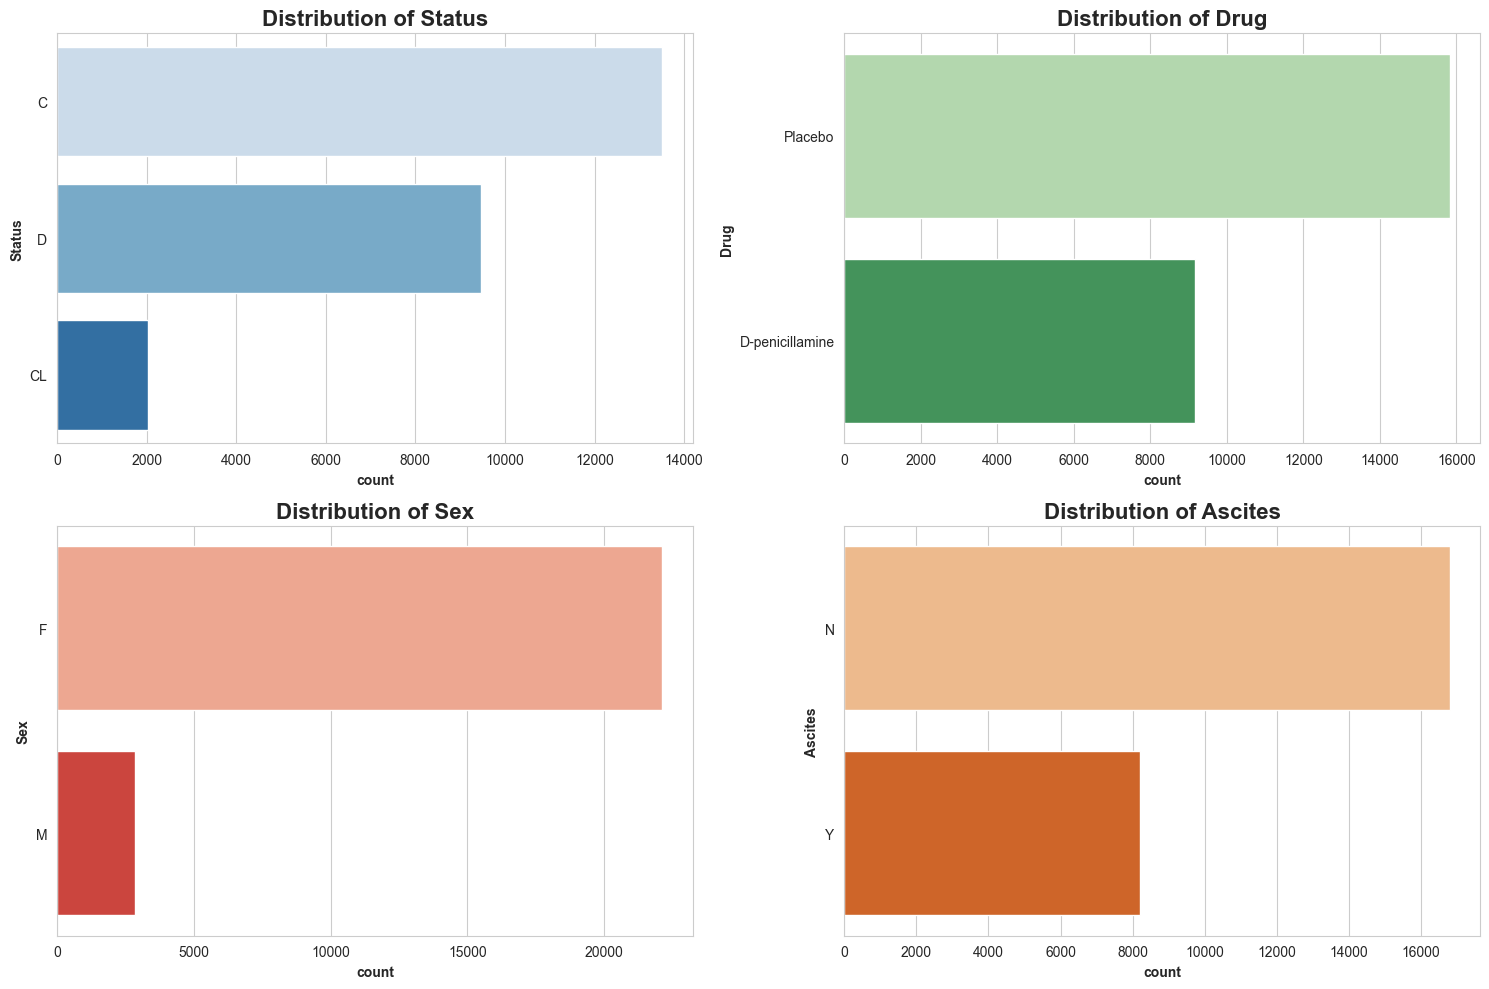

In [79]:
display(HTML(styled_heading("Visualizations using Boxplot:", background_color='#2E8B57', text_color='#FFFFFF')))
# Setting the style for seaborn
sns.set_style("whitegrid")

# Creating a figure and subplots
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# Plotting the 'Status' column with a custom color palette
sns.countplot(y='Status', data=dataset, ax=axes[0, 0], palette='Blues')
axes[0, 0].set_title('Distribution of Status', fontweight='bold', fontsize=16)
axes[0, 0].set_xlabel(axes[0, 0].get_xlabel(), fontweight='bold')
axes[0, 0].set_ylabel(axes[0, 0].get_ylabel(), fontweight='bold')

# Plotting the 'Drug' column with a custom color palette
sns.countplot(y='Drug', data=dataset, ax=axes[0, 1], palette='Greens')
axes[0, 1].set_title('Distribution of Drug', fontweight='bold', fontsize=16)
axes[0, 1].set_xlabel(axes[0, 1].get_xlabel(), fontweight='bold')
axes[0, 1].set_ylabel(axes[0, 1].get_ylabel(), fontweight='bold')

# Plotting the 'Sex' column with a custom color palette
sns.countplot(y='Sex', data=dataset, ax=axes[1, 0], palette='Reds')
axes[1, 0].set_title('Distribution of Sex', fontweight='bold', fontsize=16)
axes[1, 0].set_xlabel(axes[1, 0].get_xlabel(), fontweight='bold')
axes[1, 0].set_ylabel(axes[1, 0].get_ylabel(), fontweight='bold')

# Plotting the 'Ascites' column with a custom color palette
sns.countplot(y='Ascites', data=dataset, ax=axes[1, 1], palette='Oranges')
axes[1, 1].set_title('Distribution of Ascites', fontweight='bold', fontsize=16)
axes[1, 1].set_xlabel(axes[1, 1].get_xlabel(), fontweight='bold')
axes[1, 1].set_ylabel(axes[1, 1].get_ylabel(), fontweight='bold')

# Adjusting the layout
plt.tight_layout()

# Showing the plots
plt.show()


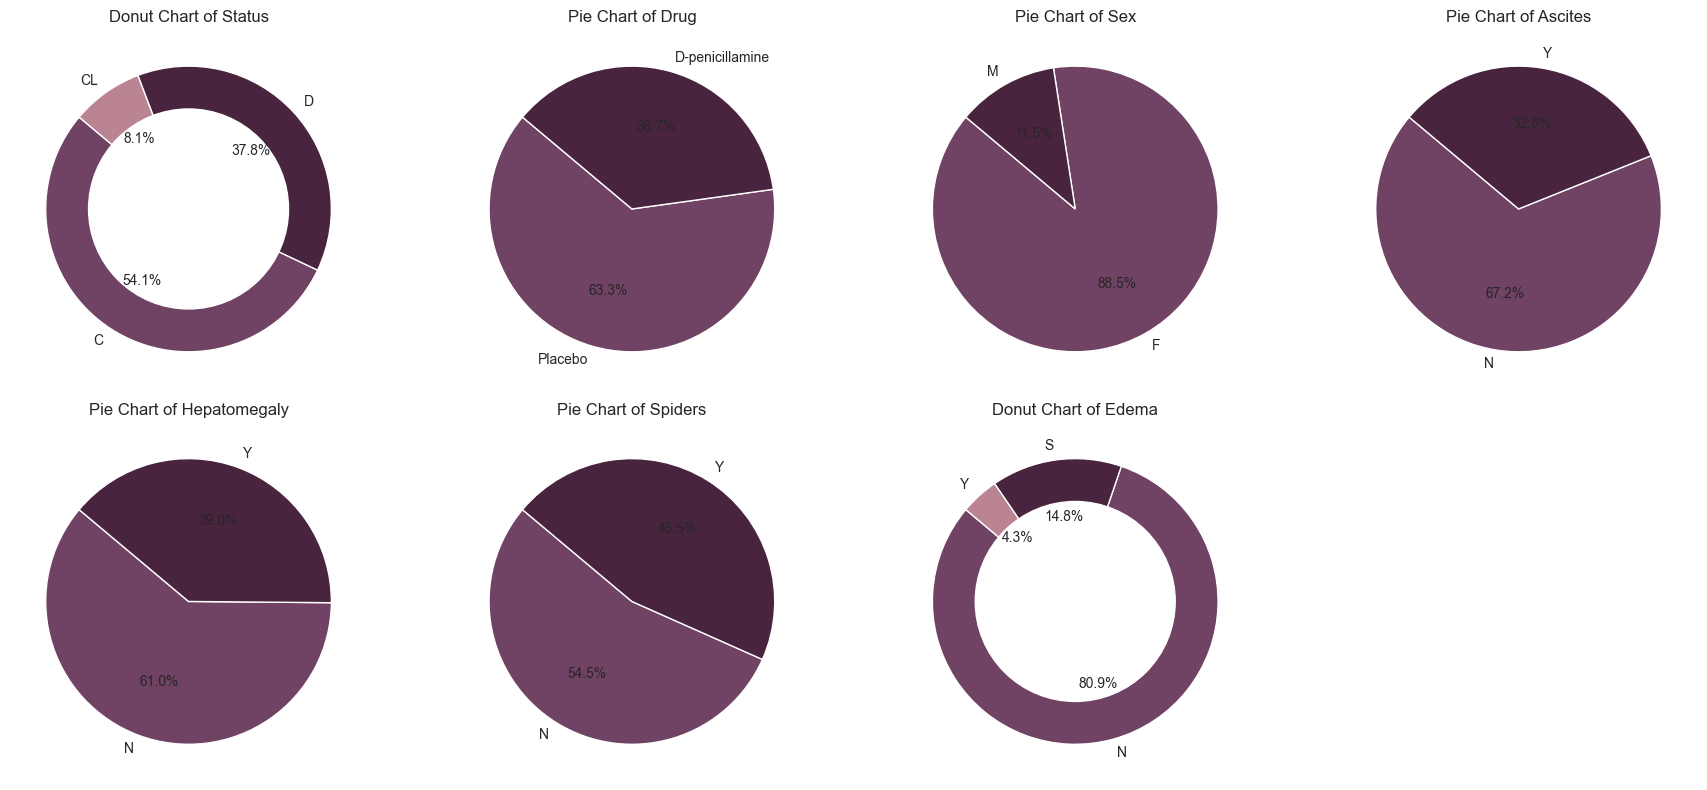

In [80]:
display(HTML(styled_heading("<b><u>Visualizations Using types of Charts:</u></b>", background_color='#000000', text_color='#FFFFFF')))


# Setting the style for seaborn
sns.set_style("whitegrid")

# Creating the subplots based on the number of category_columns
fig, axis = plt.subplots(2, 4, figsize=(18, 8))

# Flattening the axis array for easy iteration
axis = axis.flatten()
category_columns = ['Status', 'Drug', 'Sex', 'Ascites', 'Hepatomegaly', 'Spiders', 'Edema']

# Plotting each category variable
for i, column in enumerate(category_columns):
    # Pie chart for columns with very few unique values (<= 2)
    if len(dataset[column].unique()) <= 2:
        axis[i].pie(dataset[column].value_counts(), labels=dataset[column].value_counts().index, 
                   autopct='%1.1f%%', startangle=140, colors=['#704264', '#49243E']) 
        axis[i].set_title(f'Pie Chart of {column}')
    
    # Donut chart for columns with few unique values (3 to 5)
    elif 3 <= len(dataset[column].unique()) <= 5:
        wedges, texts, autotexts = axis[i].pie(dataset[column].value_counts(), labels=dataset[column].value_counts().index, 
                                              autopct='%1.1f%%', startangle=140, colors=['#704264', '#49243E', '#BB8493', '#8c564b', '#e377c2'])
        # Creating the hole for the donut effect
        axis[i].add_artist(plt.Circle((0, 0), 0.70, fc='white'))
        axis[i].set_title(f'Donut Chart of {column}')
    
    # Bar plot for more than 5 and less than 15 unique values
    elif 6 <= len(dataset[column].unique()) <= 15:
        sns.countplot(x=column, data=dataset, ax=axis[i], palette='dark')  
        axis[i].set_title(f'Bar Plot of {column}')
    
    # Violin swarm plot for columns with many unique values (> 15)
    elif len(dataset[column].unique()) > 15:
        sns.violinplot(x=column, data=dataset, ax=axis[i], palette='magma') 
        sns.swarmplot(x=column, data=dataset, color='white', alpha=0.5, ax=axis[i])  
        axis[i].set_title(f'Violin Swarm Plot of {column}')

# Hiding any extra subplots if there are fewer than 8 categorical columns
for j in range(len(category_columns), len(axis)):
    fig.delaxes(axis[j])

plt.tight_layout()
plt.show()



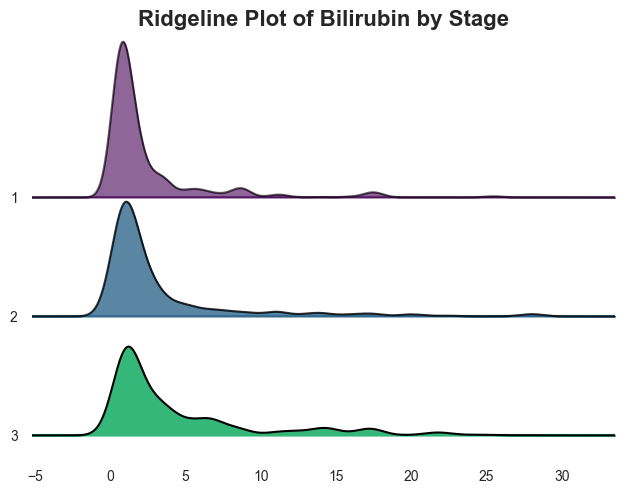

In [81]:
import joypy

display(HTML(styled_heading("<b><u>Ridgelineplots for Stages Rows</u></b>", background_color='#000000', text_color='#FFFFFF')))
joypy.joyplot(data=dataset, by='Stage', column='Bilirubin', colormap=plt.cm.viridis, fade=True)
plt.title('Ridgeline Plot of Bilirubin by Stage', fontsize=16, fontweight='bold')
plt.show()

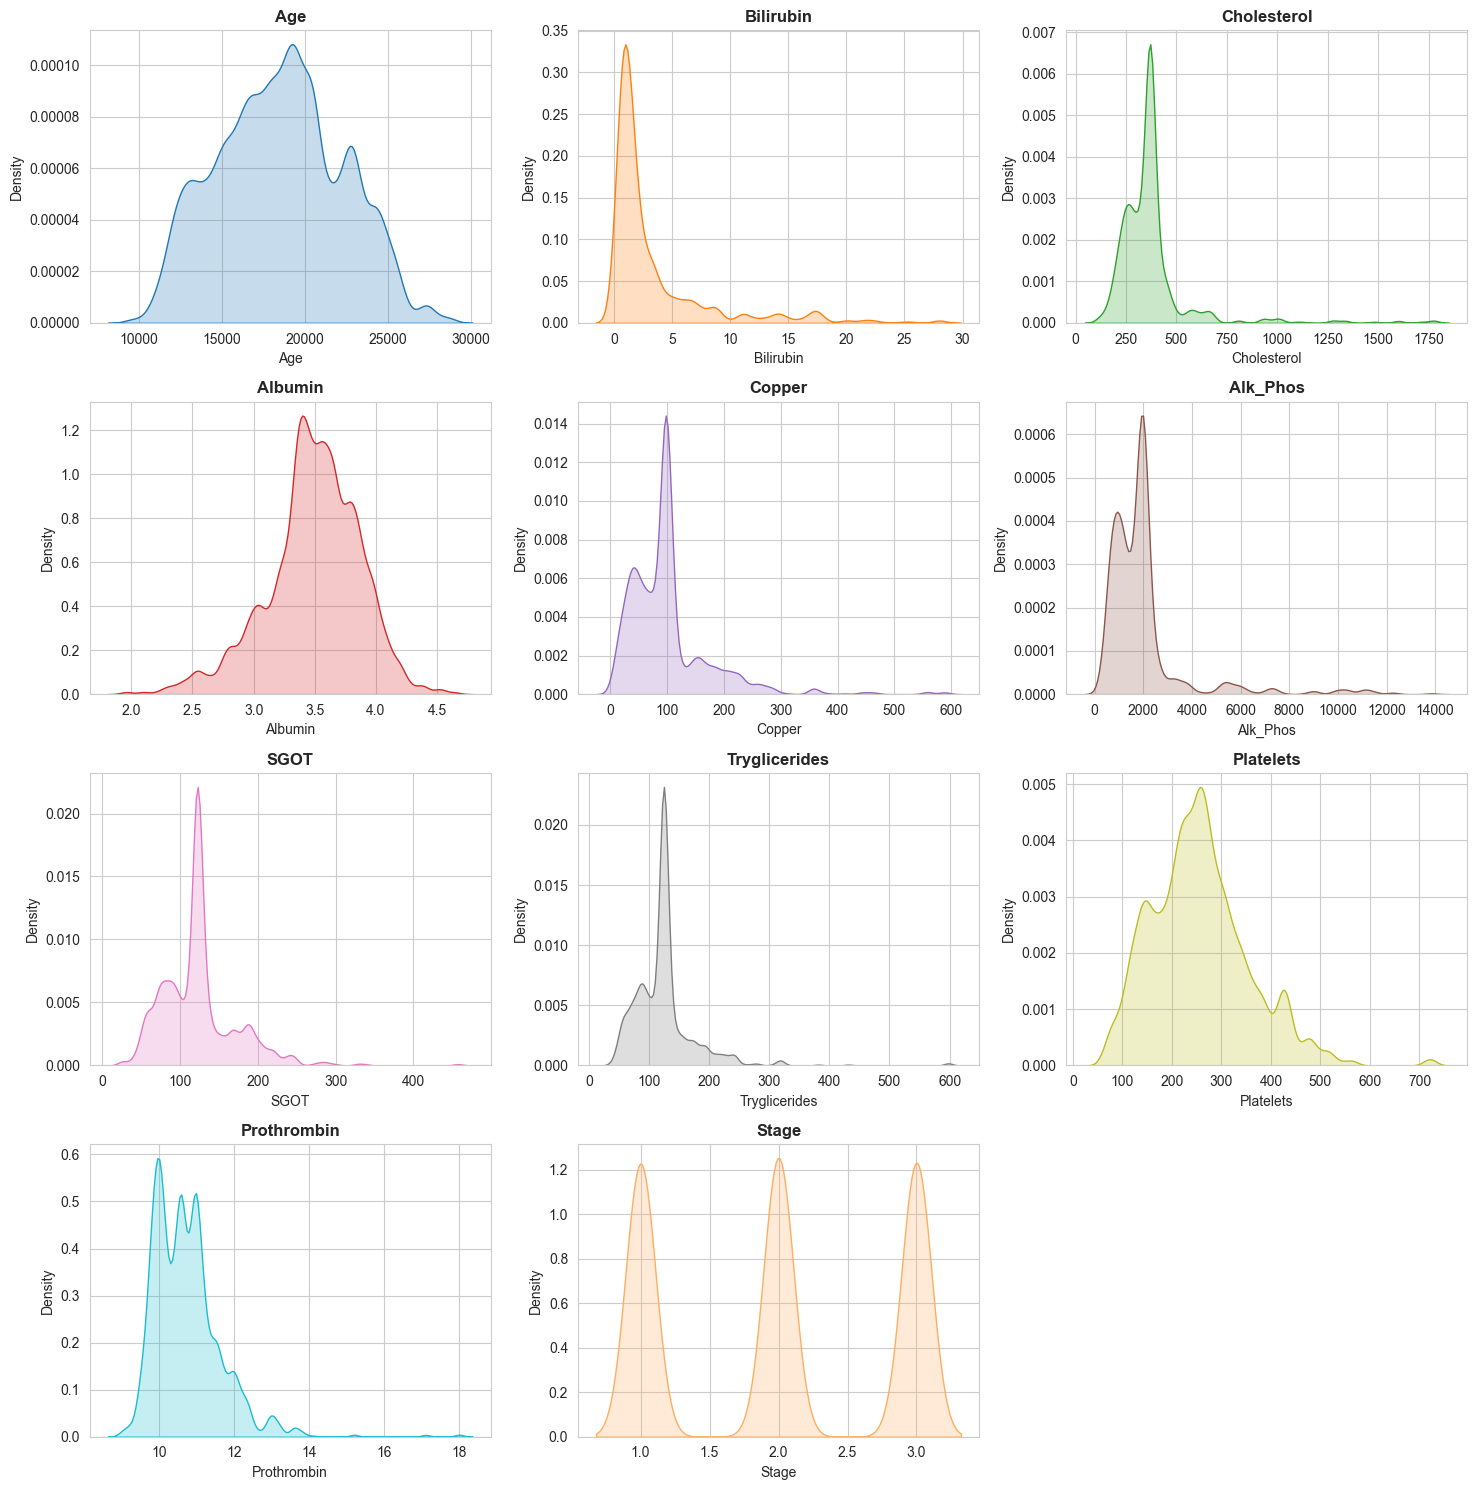

In [82]:
display(HTML(styled_heading("<b><u>KDElineplots for Clear Visualizations of Numerical Columns</u></b>", background_color='#000000', text_color='#FFFFFF')))

# Defining colours and columns
colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b', '#e377c2', '#7f7f7f', '#bcbd22', '#17becf', '#fdae61']

columns = ['Age', 'Bilirubin', 'Cholesterol', 'Albumin', 'Copper', 'Alk_Phos', 'SGOT', 'Tryglicerides', 'Platelets', 'Prothrombin', 'Stage']
num_rows = 4
num_cols = 3
fig, axes = plt.subplots(num_rows, num_cols, figsize=(15, 15))
axes = axes.flatten()

for i, column in enumerate(columns):
    ax = axes[i]
    color = colors[i % len(colors)] 
    sns.kdeplot(data=dataset[column], ax=ax, fill=True, color=color)
    ax.set_title(column, fontsize=12, fontweight='bold')
    ax.set_ylabel('Density', fontsize=10)

# Hiding any extra subplots if there are fewer columns than axes
for j in range(len(columns), len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()



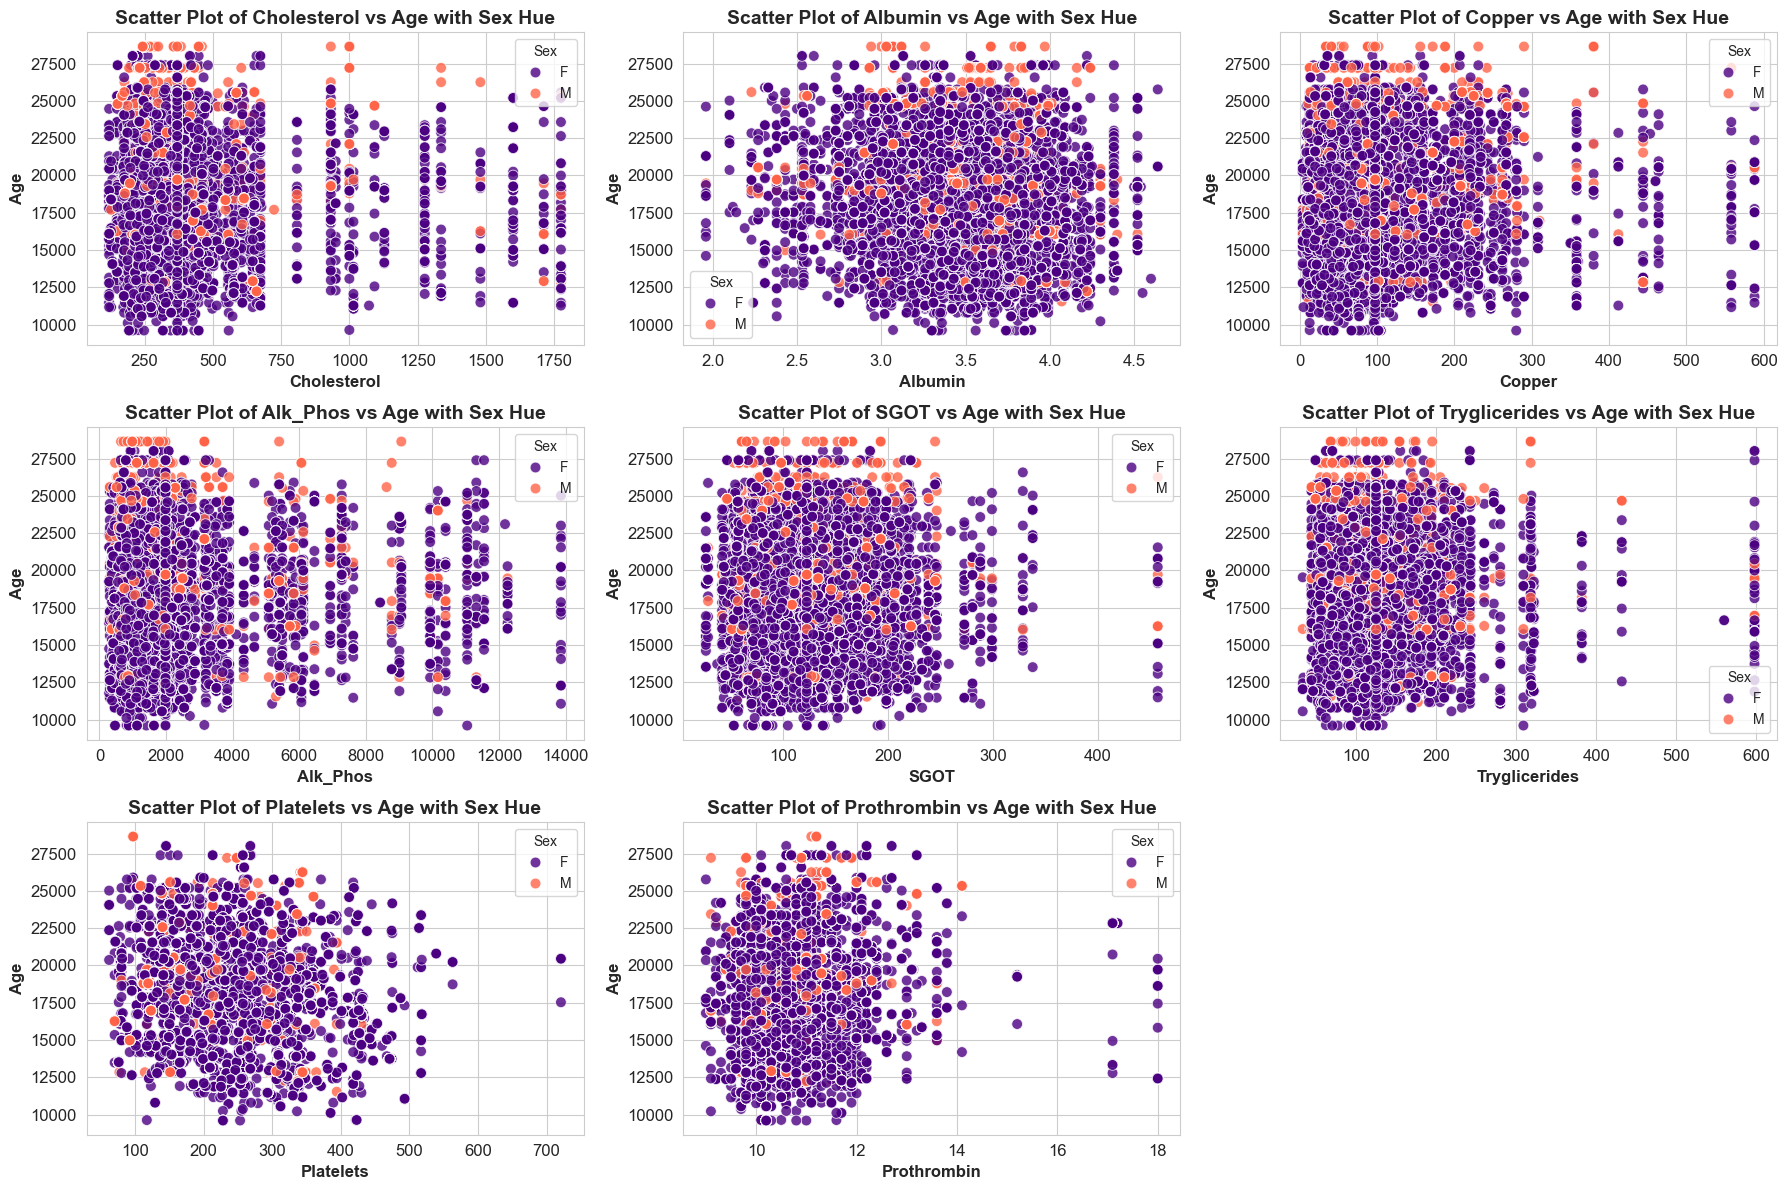

In [83]:
display(HTML(styled_heading("<b><u>Scatterplots for Visualizations of all columns</u></b>", background_color='#000000', text_color='#FFFFFF')))

# Selecting the columns for bivariate analysis
bivariate_columns = ['Cholesterol', 'Albumin', 'Copper', 'Alk_Phos', 'SGOT', 'Tryglicerides', 'Platelets', 'Prothrombin']

# Creating the subplots
fig, axis = plt.subplots(3, 3, figsize=(18, 12))

# Flattening the axis array for easy iteration
axis = axis.flatten()

# Defining new colors for the scatter plot points
point_colors = ['#4B0082', '#FF6347']  # Indigo and Tomato for vibrant color differentiation

# Plotting scatter plots for each pair of variables with 'Sex' as hue and changing the color of scatter plot points
for i, column in enumerate(bivariate_columns):
    sns.scatterplot(x=column, y='Age', hue='Sex', data=dataset, ax=axis[i], palette=point_colors, s=60, alpha=0.8)
    axis[i].set_title(f'Scatter Plot of {column} vs Age with Sex Hue', fontsize=14, fontweight='bold')
    axis[i].tick_params(axis='x', labelsize=12)
    axis[i].tick_params(axis='y', labelsize=12)
    axis[i].set_xlabel(column, fontsize=12, fontweight='bold')
    axis[i].set_ylabel('Age', fontsize=12, fontweight='bold')

# Hiding any extra subplots if there are fewer than 9 subplots
for j in range(len(bivariate_columns), len(axis)):
    fig.delaxes(axis[j])

plt.tight_layout()
plt.show()



Text(0.5, 1.0, 'positive correlation of gender ("Female") with SGOT')

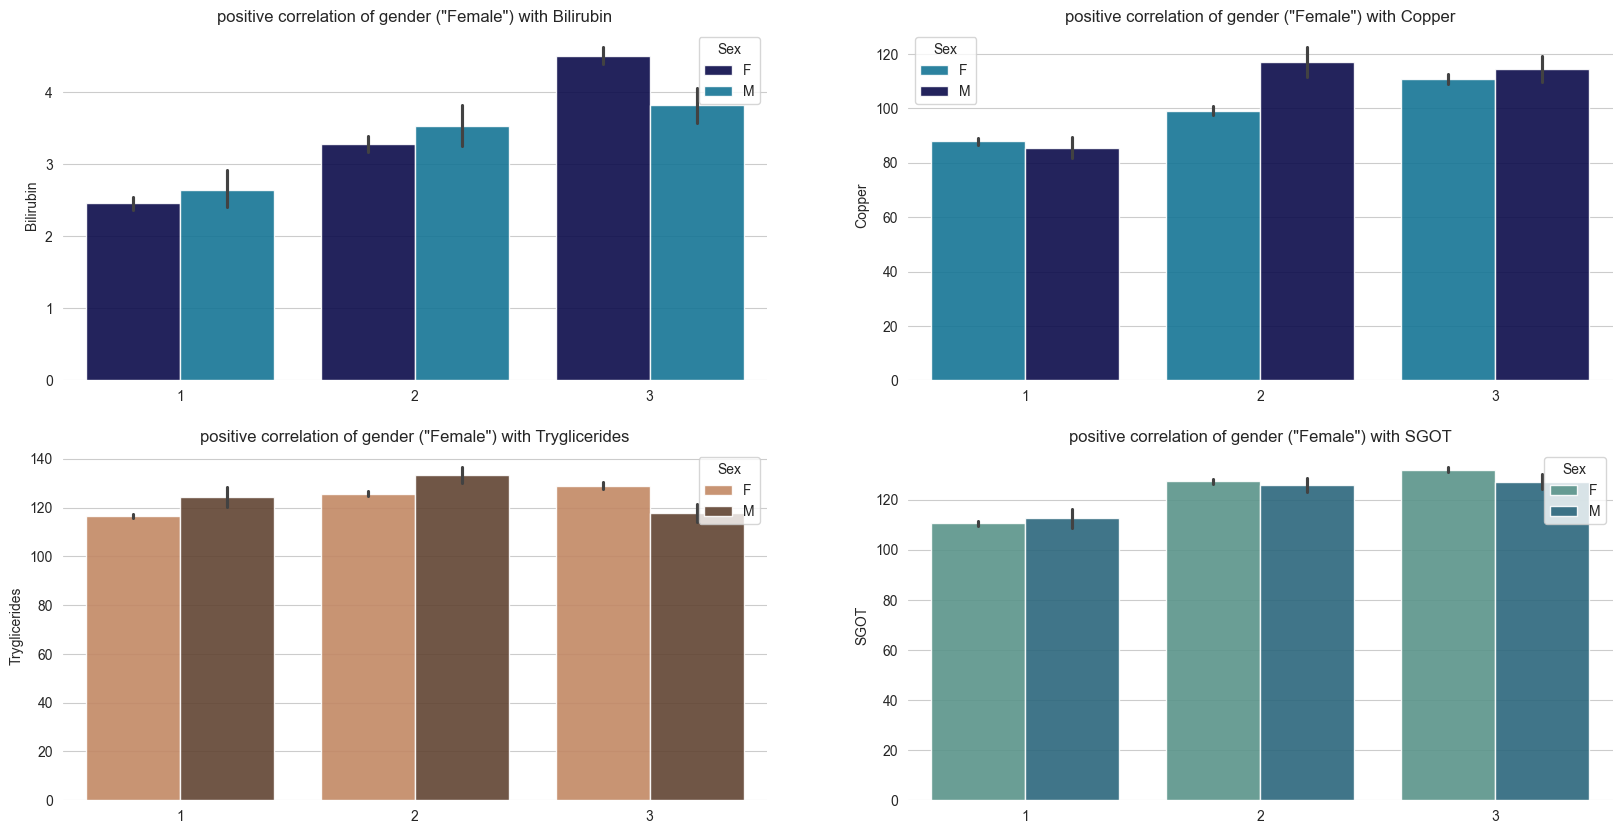

In [84]:
plt.figure(figsize=(20,10))


plt.subplot(2,2,1)
sns.barplot(x=dataset['Stage'],y = dataset["Bilirubin"],hue=dataset['Sex'], palette='ocean', alpha=0.9)
sns.despine(top=True, right=True, bottom=True, left=True)
plt.tick_params(axis='both', which='both', bottom=False, top=False, left=False)
plt.xlabel('')
plt.title('positive correlation of gender ("Female") with Bilirubin')


plt.subplot(2,2,2)
sns.barplot(x=dataset['Stage'],y = dataset["Copper"],hue=dataset['Sex'], palette='ocean_r', alpha=0.9)
sns.despine(top=True, right=True, bottom=True, left=True)
plt.tick_params(axis='both', which='both', bottom=False, top=False, left=False)
plt.xlabel('')
plt.title('positive correlation of gender ("Female") with Copper')


plt.subplot(2,2,3)
sns.barplot(x=dataset['Stage'],y = dataset["Tryglicerides"],hue=dataset['Sex'], palette='copper_r', alpha=0.9)
sns.despine(top=True, right=True, bottom=True, left=True)
plt.tick_params(axis='both', which='both', bottom=False, top=False, left=False)
plt.xlabel('')
plt.title('positive correlation of gender ("Female") with Tryglicerides')

plt.subplot(2,2,4)
sns.barplot(x=dataset['Stage'],y = dataset["SGOT"],hue=dataset['Sex'], palette='crest', alpha=0.9)
sns.despine(top=True, right=True, bottom=True, left=True)
plt.tick_params(axis='both', which='both', bottom=False, top=False, left=False)
plt.xlabel('')
plt.title('positive correlation of gender ("Female") with SGOT')


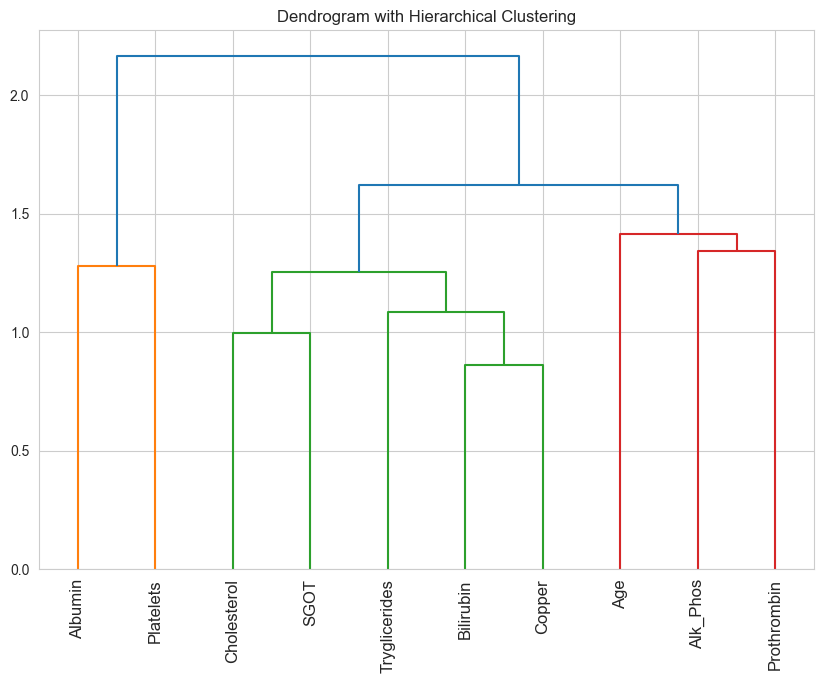

In [85]:
display(HTML(styled_heading("<b><u>Hierarchical Clustering Dendrogram for Correlation</u></b>", background_color='#000000', text_color='#FFFFFF')))

# Compute the correlation matrix
corr = dataset[['Age', 'Bilirubin', 'Cholesterol', 'Albumin', 'Copper', 'Alk_Phos', 'SGOT', 'Tryglicerides', 'Platelets', 'Prothrombin']].corr()

# Generate the linkage matrix
link = linkage(corr, method='complete')

# Plot the dendrogram
plt.figure(figsize=(10, 7))
dendrogram(link, labels=corr.columns, leaf_rotation=90)
plt.title('Dendrogram with Hierarchical Clustering')
plt.show()

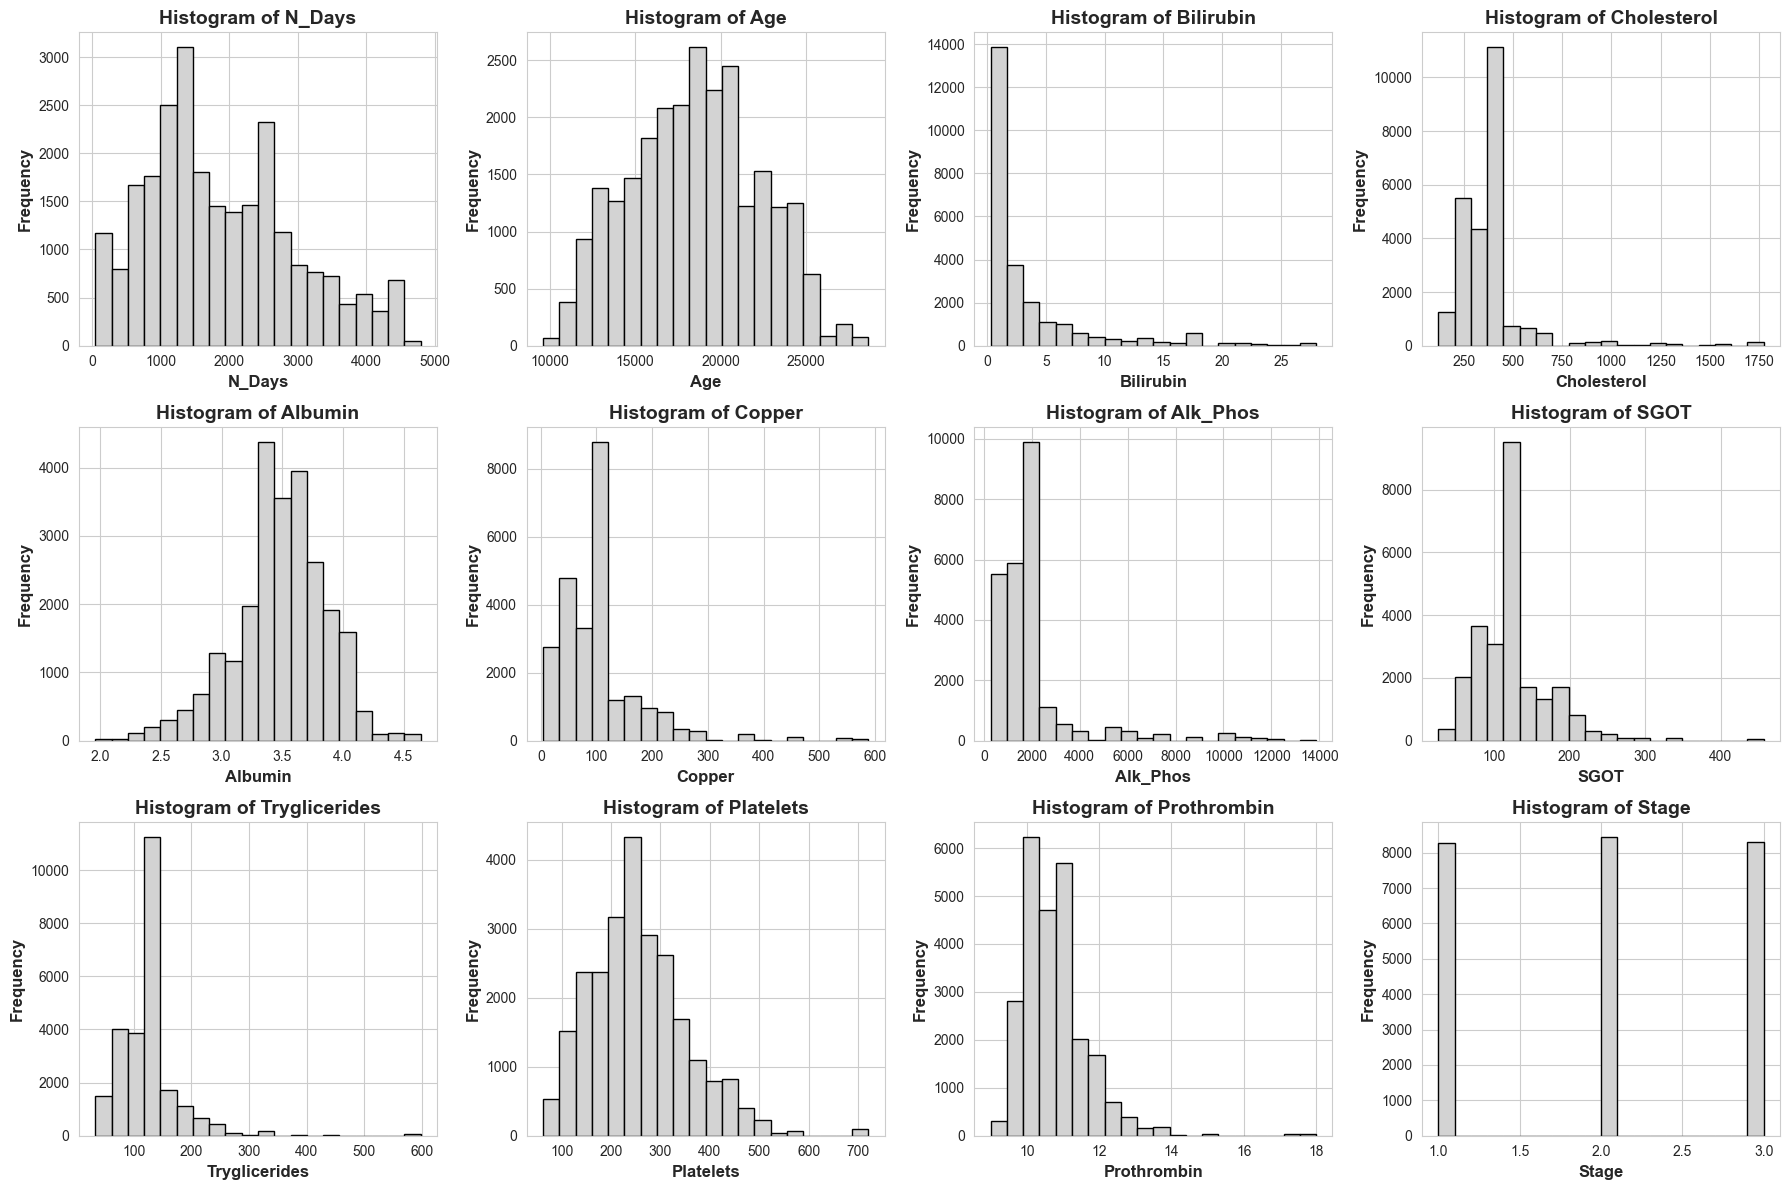

In [86]:
display(HTML(styled_heading("<b><u>Histograms For Numerical Columns</u></b>", background_color='#000000', text_color='#FFFFFF')))

# Defining the numerical columns
numerical_columns = ['N_Days', 'Age', 'Bilirubin', 'Cholesterol', 'Albumin', 'Copper', 
                     'Alk_Phos', 'SGOT', 'Tryglicerides', 'Platelets', 'Prothrombin', 'Stage']

# Creating the subplots
fig, axis = plt.subplots(3, 4, figsize=(18, 12))

# Flattening the axis array for easy iteration
axis = axis.flatten()

# Plotting the histograms for each numerical variable
for i, column in enumerate(numerical_columns):
    axis[i].hist(dataset[column], bins=20, color='lightgrey', edgecolor='black')
    axis[i].set_title(f'Histogram of {column}', fontsize=14, fontweight='bold')
    axis[i].set_xlabel(column, fontsize=12, fontweight='bold')
    axis[i].set_ylabel('Frequency', fontsize=12, fontweight='bold')

# Hiding any extra subplots if there are fewer than 12 numeric columns
for j in range(len(numerical_columns), len(axis)):
    fig.delaxes(axis[j])

plt.tight_layout()
plt.show()

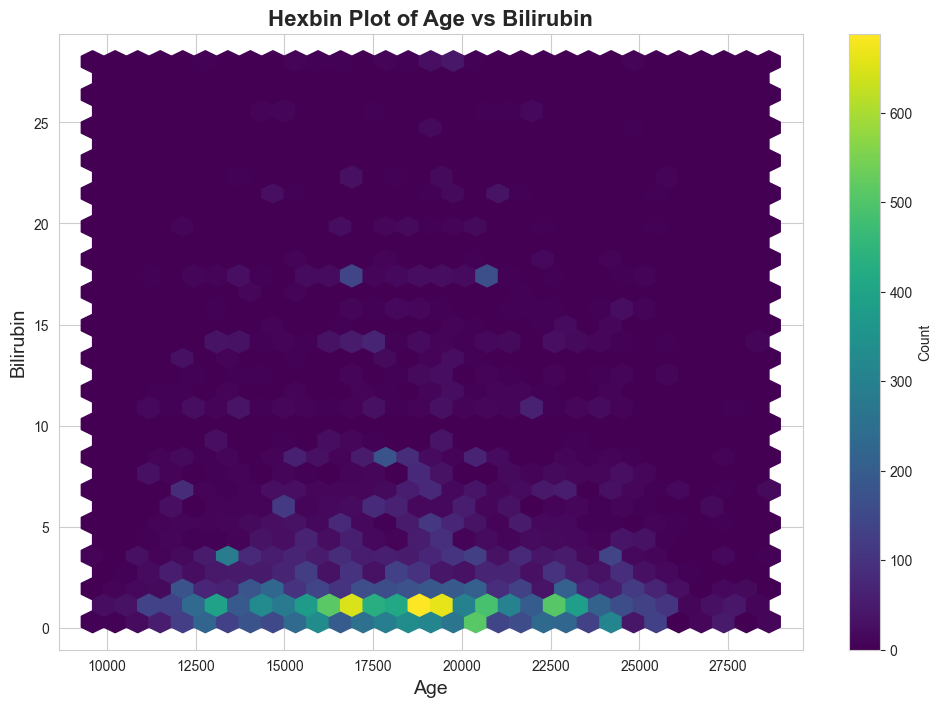

In [87]:
display(HTML(styled_heading("<b><u>Hexabin Plot of Age vs Bilirubin</u></b>", background_color='#000000', text_color='#FFFFFF')))

plt.figure(figsize=(12, 8))
plt.hexbin(dataset['Age'], dataset['Bilirubin'], gridsize=30, cmap='viridis')  
plt.colorbar(label='Count')
plt.xlabel('Age', fontsize=14)
plt.ylabel('Bilirubin', fontsize=14)
plt.title('Hexbin Plot of Age vs Bilirubin', fontsize=16, fontweight='bold')
plt.show()


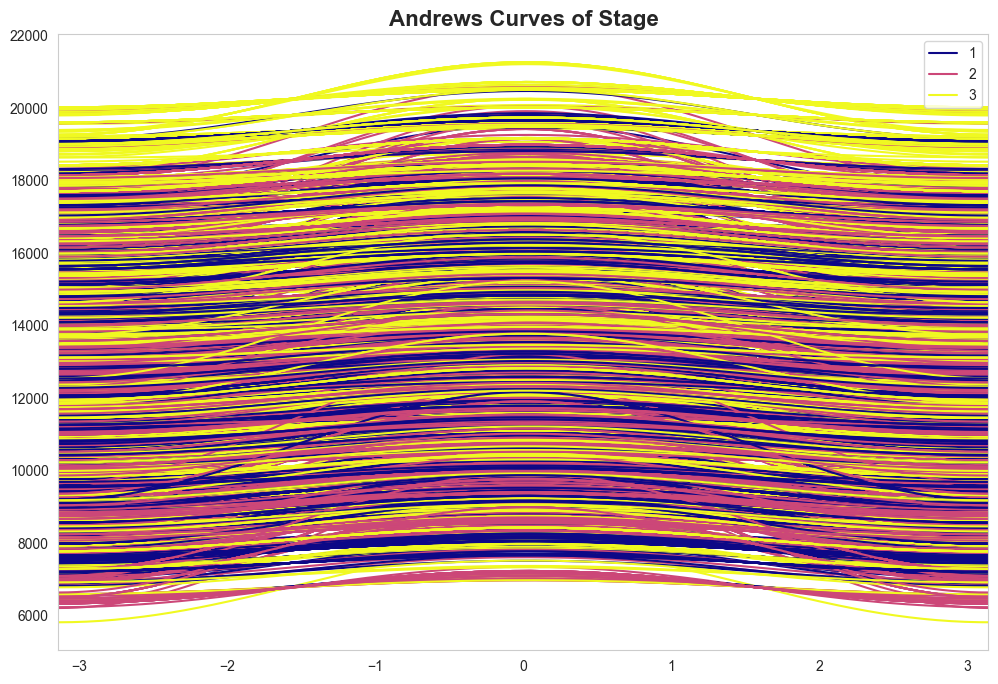

In [88]:
display(HTML(styled_heading("<b><u>Andrew Curves</u></b>", background_color='#000000', text_color='#FFFFFF')))

# Andrews Curves plot with 'plasma' colormap
plt.figure(figsize=(12, 8))
andrews_curves(dataset[['Stage', 'Age', 'Bilirubin', 'Cholesterol', 'Albumin']], 'Stage', colormap='plasma')
plt.title('Andrews Curves of Stage', fontsize=16, fontweight='bold')
plt.show()


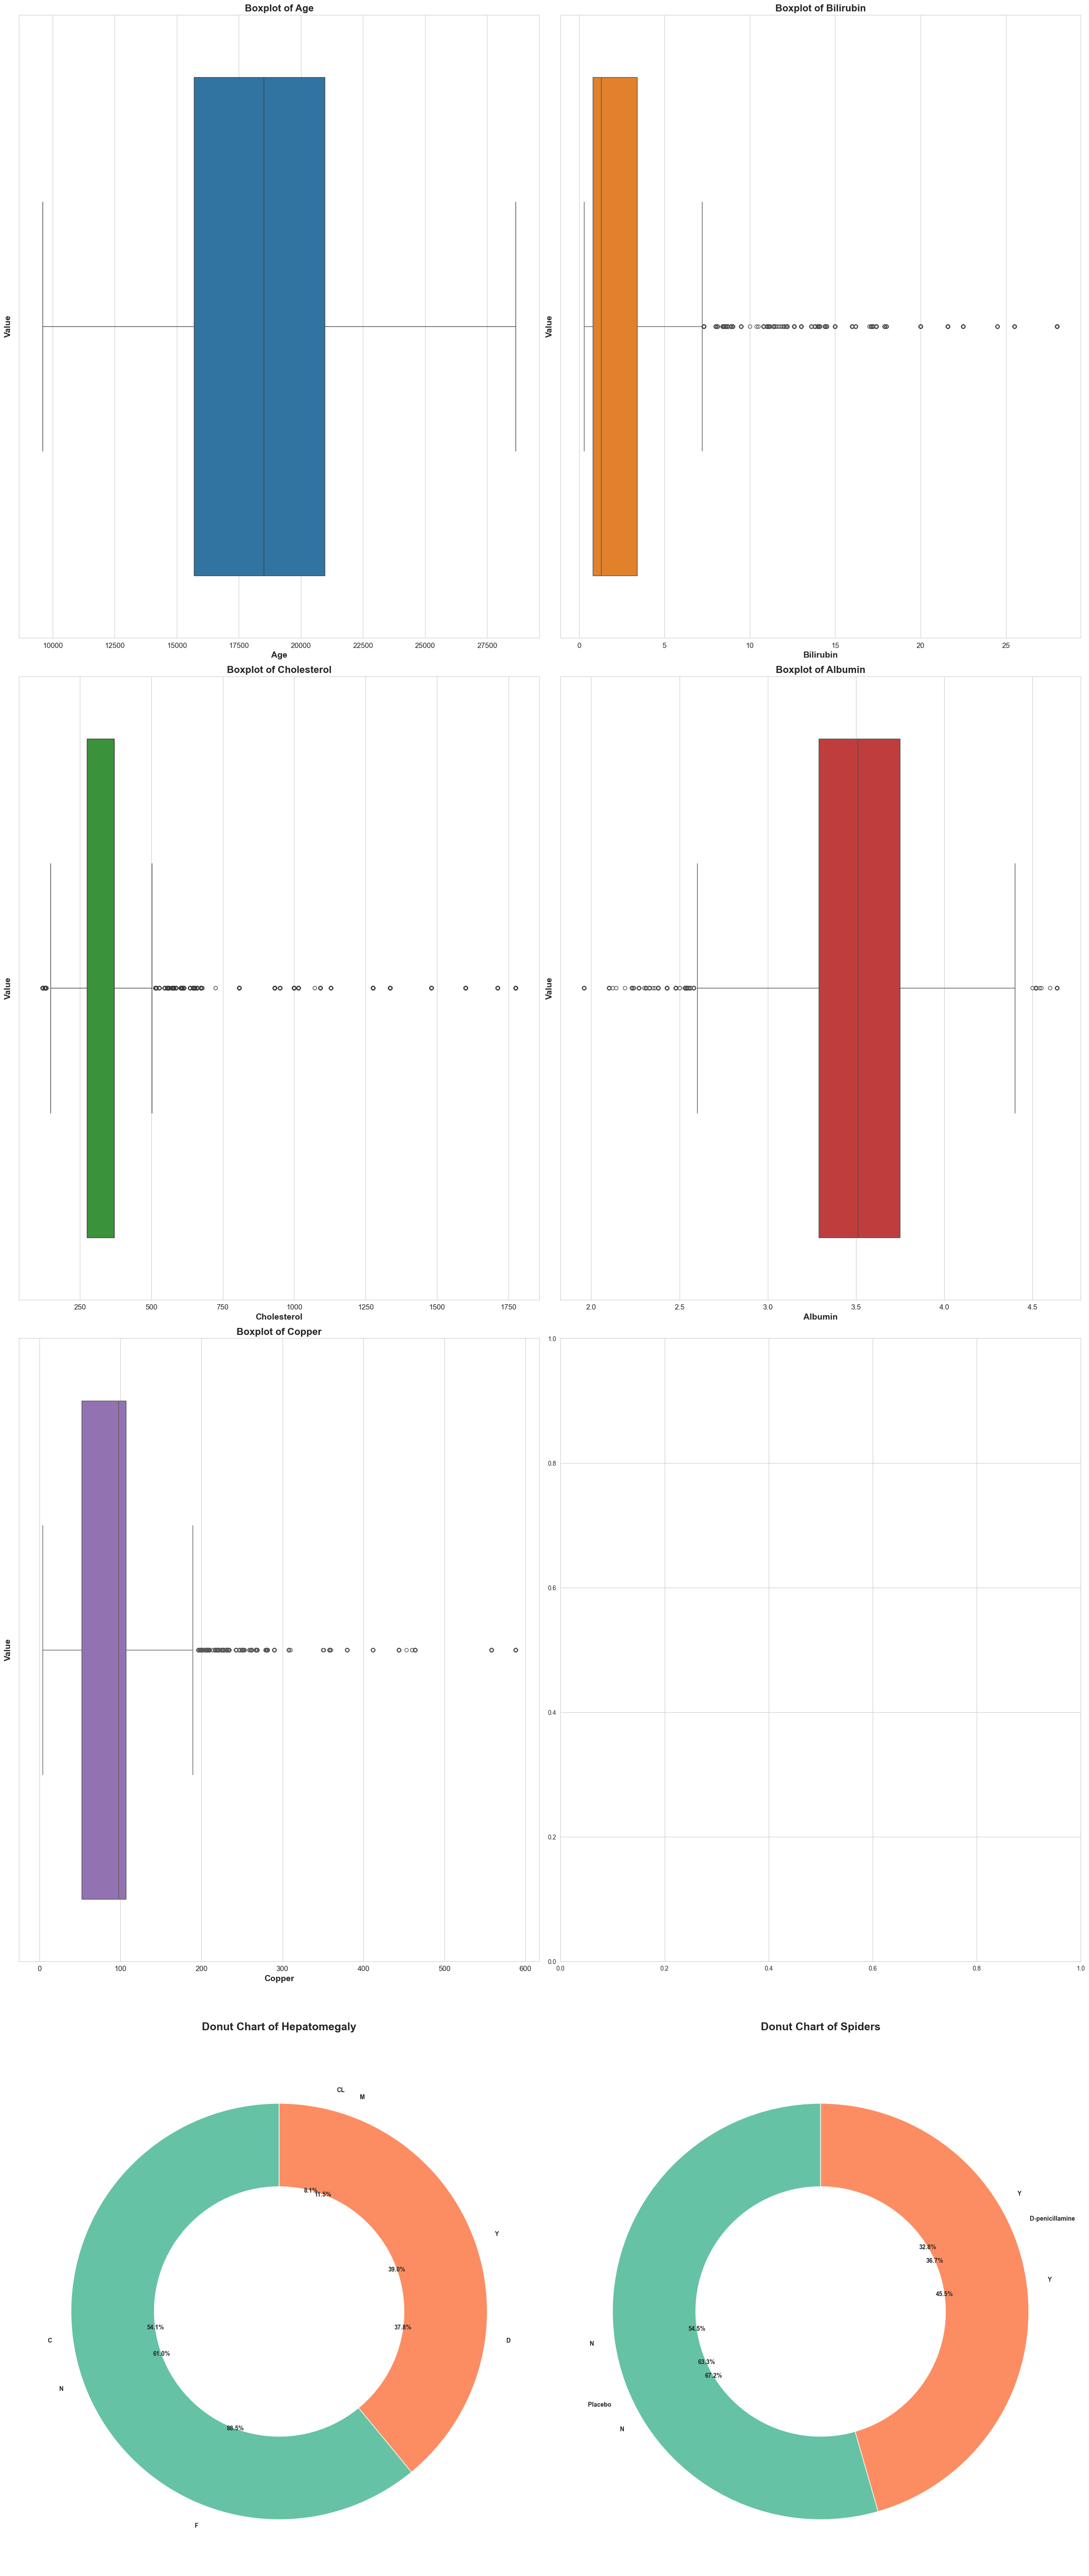

In [89]:
display(HTML(styled_heading("<b><u>Outlier Detections</u></b>", background_color='#000000', text_color='#FFFFFF')))
    
colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b', '#e377c2']  
pie_colors = ['#66c2a5', '#fc8d62', '#8da0cb', '#e78ac3']  

# Selecting columns
numerical_columns = ['Age', 'Bilirubin', 'Cholesterol', 'Albumin', 'Copper']
categorical_columns = ['Status', 'Drug', 'Sex', 'Ascites', 'Hepatomegaly', 'Spiders']

# Setting the style for seaborn
sns.set_style("whitegrid")

# Calculating the number of subplot rows needed for numerical columns
num_numerical_cols = len(numerical_columns)
num_subplot_rows = (num_numerical_cols + 1) // 2  # Ensure at least one row

# Creating the figure and subplots
fig, axes = plt.subplots(num_subplot_rows + 1, 2, figsize=(25, 15 * (num_subplot_rows + 1)))

# Plotting boxplots for numerical columns
for i, col in enumerate(numerical_columns):
    row_index = i // 2
    col_index = i % 2
    sns.boxplot(x=dataset[col], ax=axes[row_index, col_index], color=colors[i % len(colors)])  # Reuse vibrant colors if more numerical columns
    axes[row_index, col_index].set_title(f'Boxplot of {col}', fontsize=16, fontweight='bold')  # Increase font size and set title to bold
    axes[row_index, col_index].set_xlabel(col, fontsize=14, fontweight='bold')  # Increase font size and set xlabel to bold
    axes[row_index, col_index].set_ylabel('Value', fontsize=14, fontweight='bold')  # Increase font size and set ylabel to bold
    axes[row_index, col_index].tick_params(axis='both', labelsize=12)  # Increase tick label size

# Plotting donut charts for categorical columns
for i, col in enumerate(categorical_columns):
    row_index = num_subplot_rows
    col_index = i % 2
    category_counts = dataset[col].value_counts()
    category_labels = category_counts.index
    category_sizes = category_counts.values
    axes[row_index, col_index].pie(category_sizes, labels=category_labels, autopct='%1.1f%%', startangle=90, colors=pie_colors, wedgeprops=dict(width=0.4, edgecolor='w'))
    axes[row_index, col_index].set_title(f'Donut Chart of {col}', fontsize=18, fontweight='bold', pad=35)  # Increase font size, set title to bold, and add padding
    axes[row_index, col_index].tick_params(axis='both', labelsize=18)  # Increase tick label size
    for text in axes[row_index, col_index].texts:
        text.set_fontweight('bold')  # Setting percentages to bold

# Adjusting layout
plt.tight_layout()
plt.show()



In [90]:
display(HTML(styled_heading("<b><u>Outlier Removal</u></b>", background_color='#000000', text_color='#FFFFFF')))

# Selecting numerical columns
numerical_columns = ['Age', 'Bilirubin', 'Cholesterol', 'Albumin', 'Copper']

# Calculating the z-scores for numerical columns
z_scores = dataset[numerical_columns].apply(zscore)

# Defining threshold for outliers (e.g., z-score > 3)
threshold = 3

# Filtering the DataFrame to exclude outliers
dataset_refined = dataset[(z_scores.abs() < threshold).all(axis=1)]

# Calculating the percentage of outliers before removal
outliers_percentage_before = (dataset.shape[0] - dataset_refined.shape[0]) / dataset.shape[0] * 100

# Displaying the shape before removing outliers
print("DataSet before removing outliers:", dataset.shape)

# Displaying the number of removed rows (outliers)
removed_rows = dataset.shape[0] - dataset_refined.shape[0]
print("Number of removed rows (outliers):", removed_rows)

# Displaying the percentage of outliers before removal
print("Percentage of outliers before removal:", outliers_percentage_before, "%")

# Updating the original DataFrame with outliers removed
dataset = dataset_refined.copy()

# Displaying the updated DataFrame shape
print("DataSet after removing outliers:", dataset.shape)


DataSet before removing outliers: (25000, 20)
Number of removed rows (outliers): 1723
Percentage of outliers before removal: 6.8919999999999995 %
DataSet after removing outliers: (23277, 20)


Columns Visualized: ['N_Days', 'Stage']


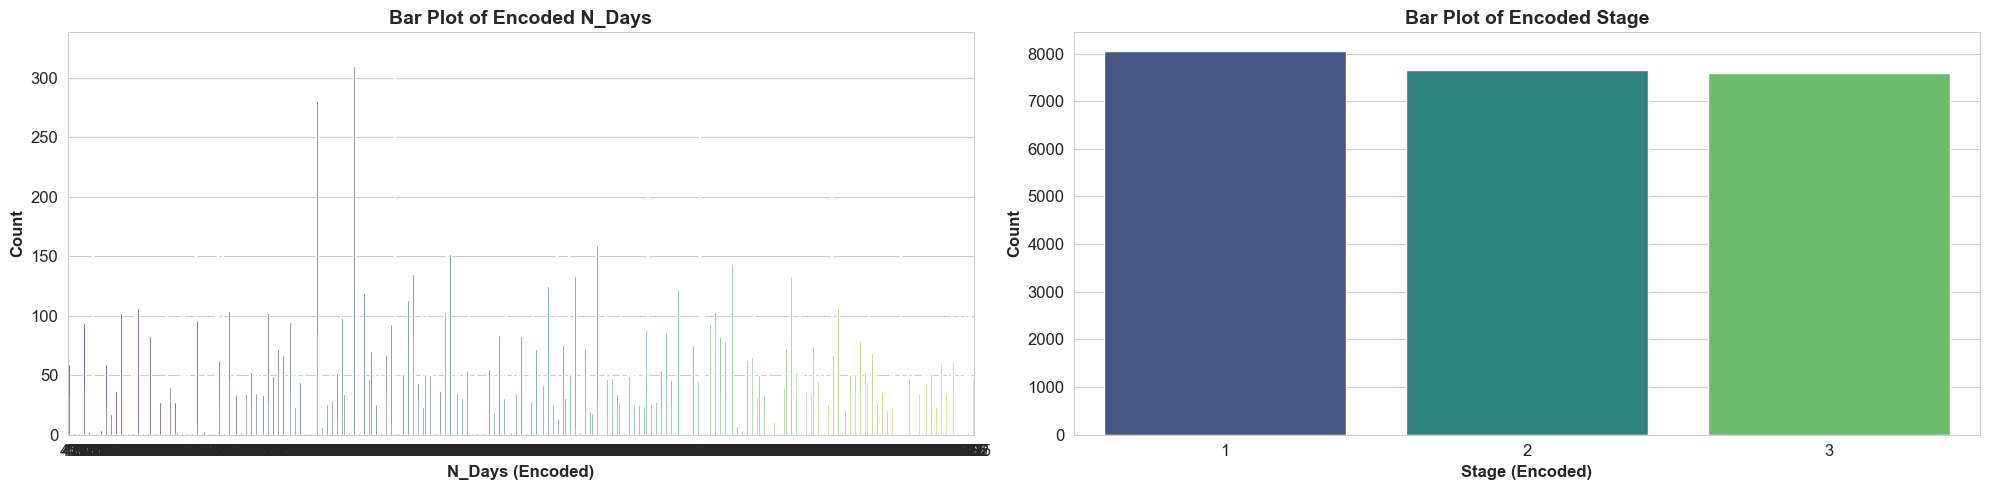

In [95]:
# Giving the heading through Display 
display(HTML(styled_heading("<b><u>Converting Characters to Binary</u></b>", background_color='#000000', text_color='#FFFFFF')))

# Binning Age Column to Create a new defined Age_Group
bins = [0, 18, 35, 60, 100]  # Define bin ranges
labels = ['Child', 'Young Adult', 'Adult', 'Senior']  # Define labels for the bins

dataset['Age_Group'] = pd.cut(dataset['Age'], bins=bins, labels=labels, right=False)

# Checking for the replaced NaN values in Age_Group if there are nay NAN
dataset['Age_Group'] = dataset['Age_Group'].cat.add_categories('Unknown').fillna('Unknown')

# Converting all the Categorical Columns to Numeric Using LabelEncoder
le = LabelEncoder()
for col in dataset.columns:
    if dataset[col].dtype == 'object' or dataset[col].dtype.name == 'category':
        dataset[col] = le.fit_transform(dataset[col])

sns.set_style("whitegrid")
encoded_columns = [col for col in dataset.columns if dataset[col].dtype in ['int64', 'category'] and col != 'Age']

# Creating Subplots for Visualization
num_encoded_cols = len(encoded_columns)
num_subplot_rows = (num_encoded_cols + 1) // 2

fig, axes = plt.subplots(num_subplot_rows, 2, figsize=(20, 5 * num_subplot_rows))
axes = axes.flatten()

# Plotting Bar Plots for Each Encoded Column
for i, col in enumerate(encoded_columns):
    sns.countplot(x=dataset[col], ax=axes[i], palette='viridis')
    axes[i].set_title(f'Bar Plot of Encoded {col}', fontsize=14, fontweight='bold')
    axes[i].set_xlabel(f'{col} (Encoded)', fontsize=12, fontweight='bold')
    axes[i].set_ylabel('Count', fontsize=12, fontweight='bold')
    axes[i].tick_params(axis='both', labelsize=12)

for j in range(len(encoded_columns), len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()


<Axes: >

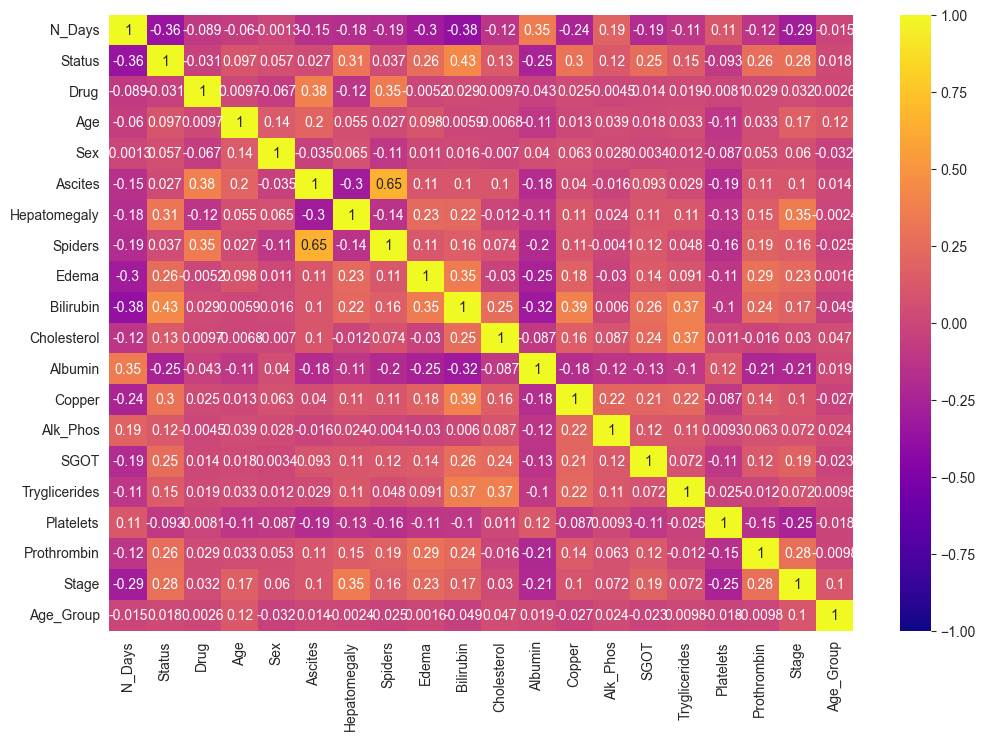

In [96]:
display(HTML(styled_heading("<b><u>Correlation Matrix</u></b>", background_color='#000000', text_color='#FFFFFF')))

plt.figure(figsize=(12,8))
sns.heatmap(dataset.corr(),annot=True,cmap='plasma',vmin=-1,vmax=1)

<Figure size 1000x800 with 0 Axes>

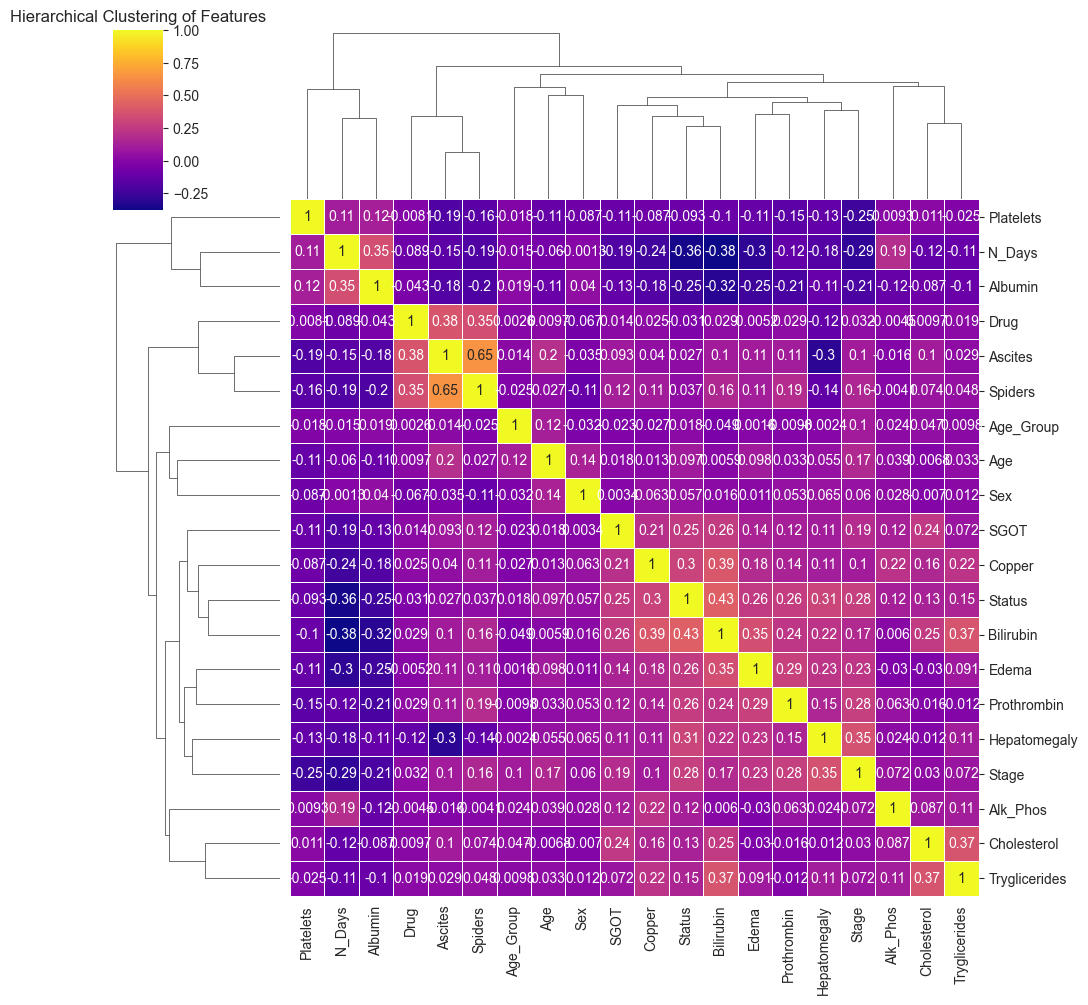

In [102]:
display(HTML(styled_heading("<b><u>Hierarchical Clustering of features</u></b>", background_color='#000000', text_color='#FFFFFF')))


# Compute the correlation matrix
corr_matrix = dataset.corr()

# Check if there are any NaN or infinite values in the correlation matrix
if np.any(np.isnan(corr_matrix)) or np.any(np.isinf(corr_matrix)):
    print("The correlation matrix contains NaN or infinite values. Cleaning the data...")

    # Replace NaN values with 0 (or you could use another strategy like filling with the mean)
    corr_matrix = corr_matrix.replace([np.inf, -np.inf], np.nan).fillna(0)

# Plot the clustermap
plt.figure(figsize=(10, 8))
sns.clustermap(corr_matrix, cmap='plasma', annot=True, linewidths=.5)
plt.title("Hierarchical Clustering of Features")
plt.show()

In [104]:
## We finished our Pre-processing and visualization part
## From here we Are starting to train and test our model and predicting the values for liver stages 
display(HTML(styled_heading("<b><u>From here we Are starting to train and test our model and predicting the values for liver stages  </u></b>", background_color='#000000', text_color='#FFFFFF')))



In [106]:
display(HTML(styled_heading("<b><u>Defining Train & Test Splits and Also Scaling Them </u></b>", background_color='#000000', text_color='#FFFFFF')))

# Defining the features and the target Columns
X = dataset.drop(columns=['Stage'], axis=1)
Y = dataset['Stage']

# Splitting the data into training and testing sets
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=42)

# Standardizing the features i.e (X) columns as the values are so variant
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [105]:
display(HTML(styled_heading("<b><u>Model Training Through Support Vector Classifier Model (SVC) </u></b>", background_color='#000000', text_color='#FFFFFF')))


# Initializing and training the SVC classifier
svc = SVC()
svc.fit(X_train_scaled, Y_train)

# Making predictions through SVC
Y_prediction_svc = svc.predict(X_test_scaled)
print("Accuracy Score:\n", accuracy_score(Y_test, Y_prediction_svc))

# Evaluating the classifier
print("\n")
print("SVC Classifier Report:\n", classification_report(Y_test, Y_prediction_svc))


Accuracy Score:
 0.8520189003436426


SVC Classifier Report:
               precision    recall  f1-score   support

           1       0.83      0.86      0.85      1584
           2       0.81      0.83      0.82      1538
           3       0.91      0.87      0.89      1534

    accuracy                           0.85      4656
   macro avg       0.85      0.85      0.85      4656
weighted avg       0.85      0.85      0.85      4656



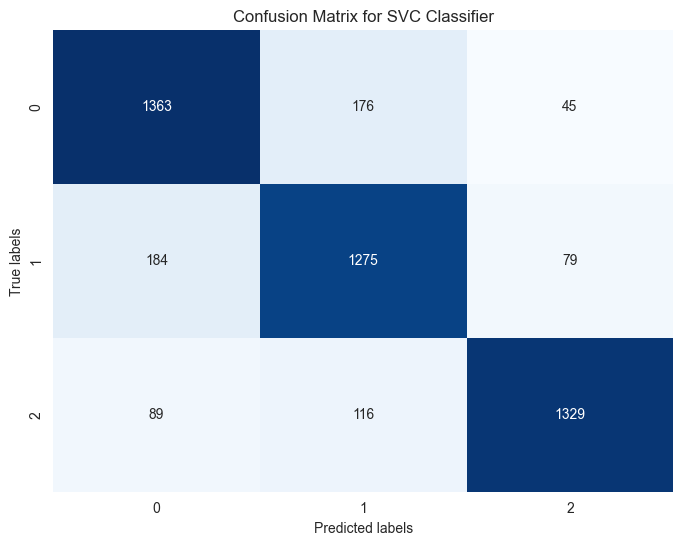

In [107]:
display(HTML(styled_heading("<b><u> Confusion Matrix plotting </u></b>", background_color='#000000', text_color='#FFFFFF')))

# Calculating the confusion matrix
cm_svc = confusion_matrix(Y_test, Y_prediction_svc)

# Plotting the confusion matrix as a heatmap for predictions
plt.figure(figsize=(8, 6))
sns.heatmap(cm_svc, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix for SVC Classifier')
plt.show()

In [108]:
display(HTML(styled_heading("<b><u> Model Evaluation and Parameters Connecting </u></b>", background_color='#000000', text_color='#FFFFFF')))

# Defining preprocessing steps for numerical features
numerical_features = ['N_Days', 'Age', 'Bilirubin', 'Cholesterol', 'Albumin', 'Copper', 'Alk_Phos', 'SGOT', 'Tryglicerides', 'Platelets', 'Prothrombin']
numerical_transformer = Pipeline(steps=[('imputer', SimpleImputer(strategy='median')),('scaler', StandardScaler())])

# Using SelectKBest with f_classif score function for Dimensionality Reduction
selector = SelectKBest(score_func=f_classif)

# Combining the preprocessing and feature selection steps for model training 
Refined_feature_selection = ColumnTransformer(transformers=[('num', numerical_transformer, numerical_features)])

# Defining the models and pipelines
models = {
    'DecisionTree': DecisionTreeClassifier(),
    'RandomForest': RandomForestClassifier(),
    'KNN': KNeighborsClassifier()
}

pipelines = {}
for name, model in models.items():
    pipelines[name] = Pipeline(steps=[('preprocessor', Refined_feature_selection),('selector', selector),('model', model)])

# Defining the hyperparameters for each model
param_grids = {
    'DecisionTree': {'selector__k': [2, 4, 6]},
    'RandomForest': {'selector__k': [2, 4, 6], 'model__n_estimators': [100, 200, 300]},
    'KNN': {'selector__k': [2, 4, 6], 'model__n_neighbors': [3, 5, 7]}
}

# Performing the GridSearchCV for each model
results = {}
for name, pipeline in pipelines.items():
    grid_search = GridSearchCV(pipeline, param_grid=param_grids[name], cv=5, scoring='accuracy')
    grid_search.fit(X_train, Y_train)
    results[name] = grid_search

# Evaluating the different models
for name, result in results.items():
    print(f"Model: {name}")
    print("Best parameters:", result.best_params_)
    print("Train Accuracy:", result.best_score_)
    Y_predictions_varied_models = result.predict(X_test)
    print("Test Accuracy:", accuracy_score(Y_test, Y_predictions_varied_models))
    print("Precision:", precision_score(Y_test, Y_predictions_varied_models, average='weighted'))
    print("Recall:", recall_score(Y_test, Y_predictions_varied_models, average='weighted'))


Model: DecisionTree
Best parameters: {'selector__k': 4}
Train Accuracy: 0.9255142554372509
Test Accuracy: 0.935352233676976
Precision: 0.9353122515268552
Recall: 0.935352233676976
Model: RandomForest
Best parameters: {'model__n_estimators': 300, 'selector__k': 6}
Train Accuracy: 0.9495733389081524
Test Accuracy: 0.9568298969072165
Precision: 0.9567969650969659
Recall: 0.9568298969072165
Model: KNN
Best parameters: {'model__n_neighbors': 3, 'selector__k': 4}
Train Accuracy: 0.9010260022058982
Test Accuracy: 0.9085051546391752
Precision: 0.9087242792757778
Recall: 0.9085051546391752


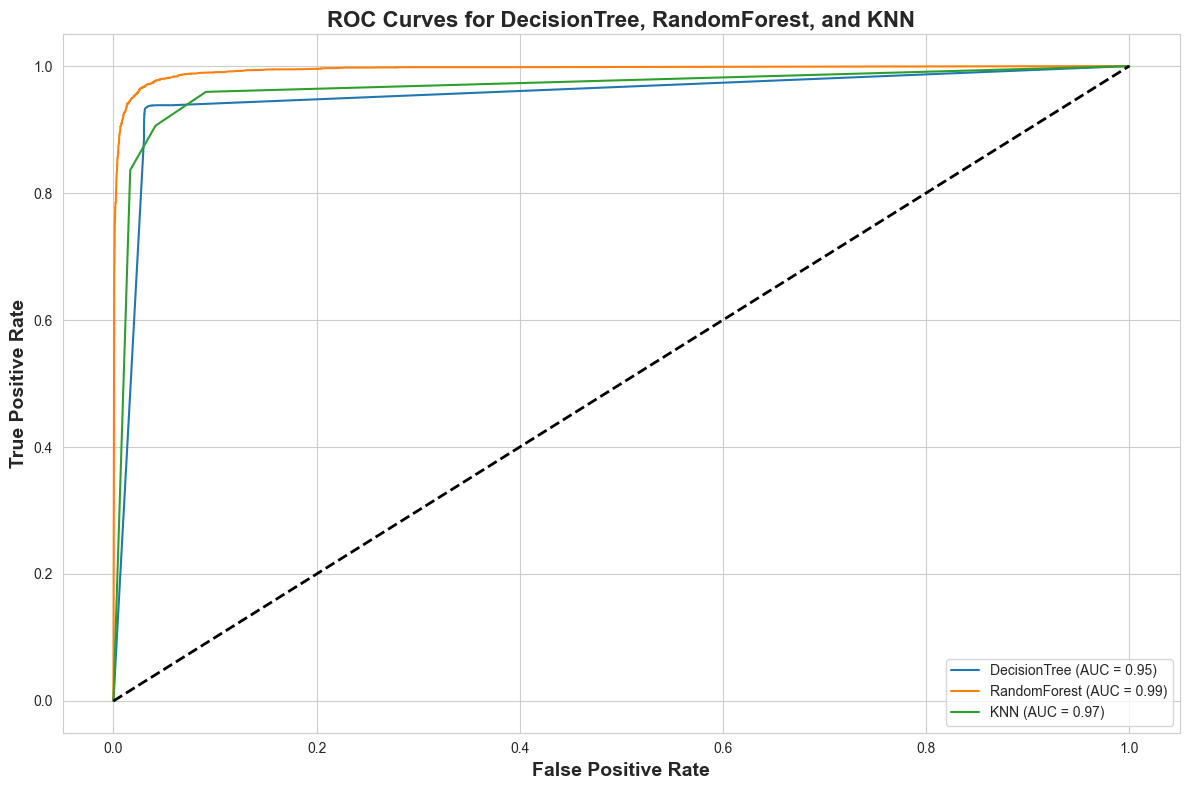

In [109]:
# Binarizing the output labels for multi-class ROC calculation
unique_labels = np.unique(Y_test)
Y_test_bin = label_binarize(Y_test, classes=unique_labels)

model_probabilities = {}
for name, result in results.items():
    try:
        # Predicting the probabilities for each class using the model
        y_pred_prob = result.best_estimator_.predict_proba(X_test)
        model_probabilities[name] = y_pred_prob
    except AttributeError:
        print(f"{name} model does not support predict_proba() or encountered an issue.")

# Plotting the ROC curves for all models
plt.figure(figsize=(12, 8))

for model_name, y_pred_prob in model_probabilities.items():
    fpr, tpr, _ = roc_curve(Y_test_bin.ravel(), y_pred_prob.ravel())
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f'{model_name} (AUC = {roc_auc:.2f})')

# Plotting the diagonal reference line
plt.plot([0, 1], [0, 1], 'k--', lw=2)

# Adding plot details
plt.xlabel('False Positive Rate', fontsize=14, fontweight='bold')
plt.ylabel('True Positive Rate', fontsize=14, fontweight='bold')
plt.title('ROC Curves for DecisionTree, RandomForest, and KNN', fontsize=16, fontweight='bold')
plt.legend(loc='lower right', fontsize=10)
plt.tight_layout()
plt.show()


Individual Confusion Matrices:

Model: DecisionTree


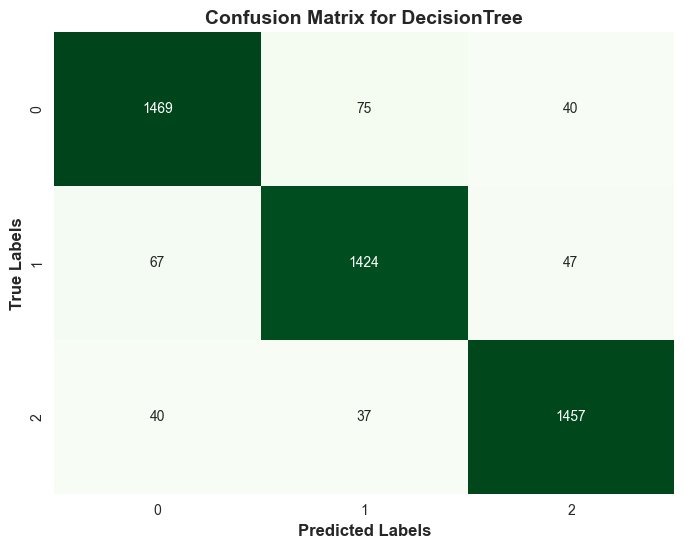

Model: RandomForest


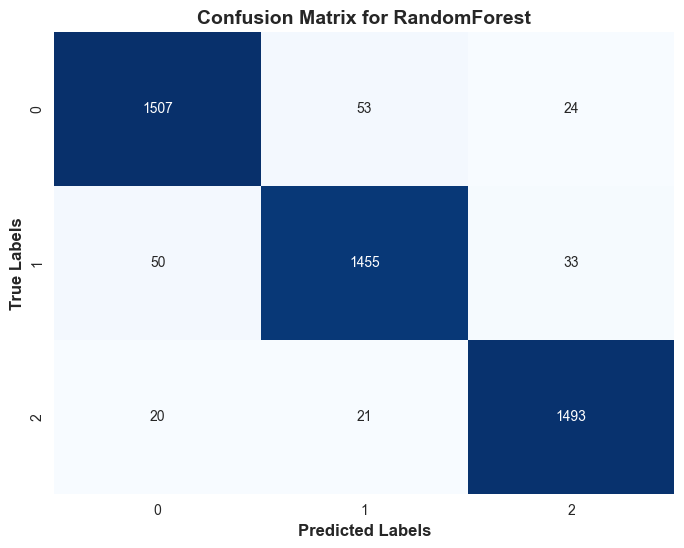

Model: KNN


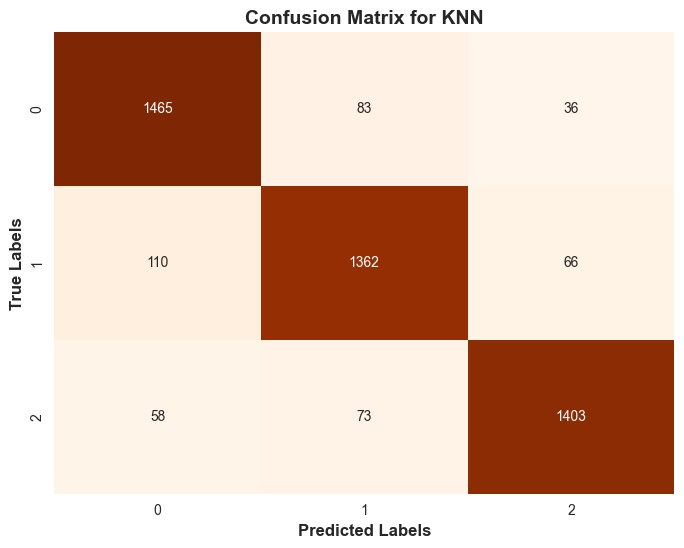


Comparison of Confusion Matrices:



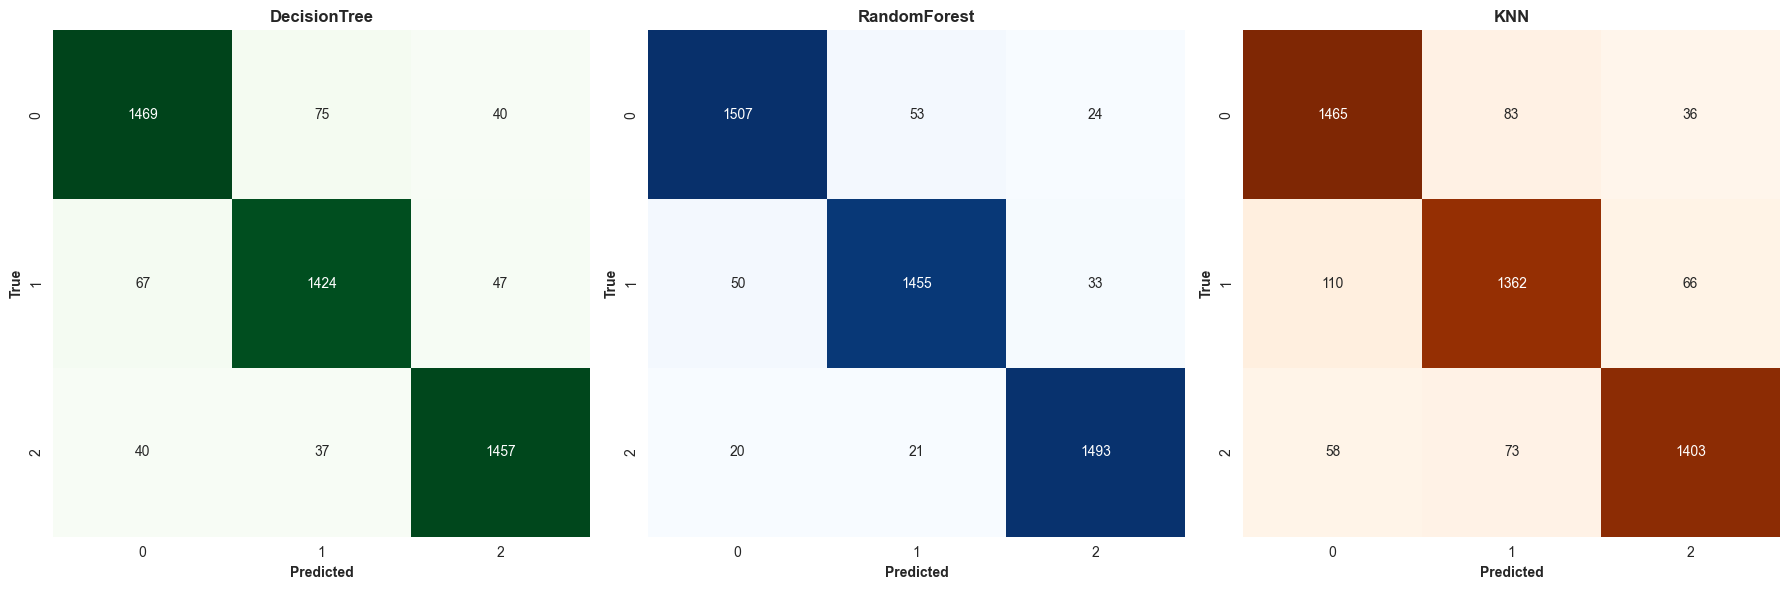

In [35]:

def styled_heading(text, background_color='#282828', text_color='#FFD700'):
    return f"""
    <div style="text-align: center; background: {background_color};
                color: {text_color}; padding: 15px; font-size: 18px;
                border-radius: 10px; margin: 20px 0;">
        {text}
    </div>
    """

display(HTML(styled_heading("<b><u>Confusion Matrix for Various Models</u></b>", background_color='#000000', text_color='#FFFFFF')))
color_maps = {'DecisionTree': 'Greens', 'RandomForest': 'Blues', 'KNN': 'Oranges'}

# Plotting confusion matrix for different algorithmns
print("\nIndividual Confusion Matrices:\n")
for name, result in results.items():
    print(f"Model: {name}")
    Y_predictions_varied_models = result.predict(X_test)  
    cm = confusion_matrix(Y_test, Y_predictions_varied_models)  
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap=color_maps.get(name, 'Blues'), cbar=False)
    plt.title(f'Confusion Matrix for {name}', fontsize=14, fontweight='bold')
    plt.xlabel('Predicted Labels', fontsize=12, fontweight='bold')
    plt.ylabel('True Labels', fontsize=12, fontweight='bold')
    plt.show()

print("\nComparison of Confusion Matrices:\n")
fig, axes = plt.subplots(1, len(results), figsize=(18, 6))
for ax, (name, result) in zip(axes, results.items()):
    Y_predictions = result.predict(X_test)  
    cm = confusion_matrix(Y_test, Y_predictions)  
    sns.heatmap(cm, annot=True, fmt='d', cmap=color_maps.get(name, 'Blues'), ax=ax, cbar=False)
    ax.set_title(f'{name}', fontsize=12, fontweight='bold')
    ax.set_xlabel('Predicted', fontsize=10, fontweight='bold')
    ax.set_ylabel('True', fontsize=10, fontweight='bold')

# Adjusting the layout
plt.tight_layout()
plt.show()

In [29]:
display(HTML(styled_heading("<b><u> Optimizing the model through stack ensembling with Catbost and LightGBM  </u></b>", background_color='#000000', text_color='#FFFFFF')))


y = Y.astype(str)


# Checking the class labels in y_train
unique_labels = np.unique(Y_train)
print("Unique class labels in y_train:", unique_labels)

# Computing the class weights for CatBoost
class_weights = compute_class_weight(class_weight='balanced', classes=unique_labels, y=Y_train)
class_weights = dict(zip(unique_labels, class_weights))
print("Class weights:", class_weights)

# Defining the preprocessing steps for numerical features
numerical_features = ['N_Days', 'Age', 'Bilirubin', 'Cholesterol', 'Albumin', 'Copper', 'Alk_Phos', 'SGOT', 'Tryglicerides', 'Platelets', 'Prothrombin']
numerical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler()),
    ('poly', PolynomialFeatures(degree=2, include_bias=False))
])

# Feature Selection
selector = SelectKBest(score_func=f_classif)
preprocessor = ColumnTransformer(transformers=[('num', numerical_transformer, numerical_features)])

# Defining the models
lgbm = LGBMClassifier(class_weight='balanced')
catboost = CatBoostClassifier(class_weights=class_weights, silent=True)

# Defining the stacking ensembles
estimators = [('LightGBM', lgbm),('CatBoost', catboost)]
stacking_model = StackingClassifier(estimators=estimators, final_estimator=LGBMClassifier())

# Defining the pipelines
pipelines = {
    'LightGBM': Pipeline(steps=[('preprocessor', preprocessor),
                                ('selector', selector),
                                ('model', lgbm)]),
    'CatBoost': Pipeline(steps=[('preprocessor', preprocessor),
                                ('selector', selector),
                                ('model', catboost)]),
    'Stacking': Pipeline(steps=[('preprocessor', preprocessor),
                                ('selector', selector),
                                ('model', stacking_model)])
}

# Defining the hyperparameters for each model
param_grids = {
    'LightGBM': {'selector__k': [2, 4, 6], 'model__num_leaves': [31, 50, 100], 'model__max_depth': [-1, 5, 10]},
    'CatBoost': {'selector__k': [2, 4, 6], 'model__iterations': [100, 200, 300]},
    'Stacking': {'selector__k': [2, 4, 6], 'model__final_estimator__n_estimators': [100, 200]}
}

# Performing the GridSearchCV for each model
results = {}
for name, pipeline in pipelines.items():
    try:
        grid_search = GridSearchCV(pipeline, param_grid=param_grids[name], cv=5, scoring='accuracy')
        grid_search.fit(X_train, Y_train)
        results[name] = grid_search
    except Exception as e:
        print(f"Error with model {name}: {e}")

# Evaluating the models
for name, result in results.items():
    print(f"Model: {name}")
    print("Best parameters:", result.best_params_)
    print("Train Accuracy:", result.best_score_)
    y_predictions_ensembling = result.predict(X_test)
    print("Test Accuracy:", accuracy_score(Y_test, y_predictions_ensembling))
    print("Precision:", precision_score(Y_test, y_predictions_ensembling, average='weighted'))
    print("Recall:", recall_score(Y_test, y_predictions_ensembling, average='weighted'))
    print("Confusion Matrix:\n", confusion_matrix(Y_test, y_predictions_ensembling))

Unique class labels in y_train: [1 2 3]
Class weights: {1: 0.9609846725499304, 2: 1.0160419053854968, 3: 1.0254419296216752}
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000390 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 300
[LightGBM] [Info] Number of data points in the train set: 14896, number of used features: 2
[LightGBM] [Info] Start training from score -1.098612
[LightGBM] [Info] Start training from score -1.098612
[LightGBM] [Info] Start training from score -1.098612


  File "c:\Users\vanda\Desktop\DA Project (Liver Cirrhosis Prediction)\librariesenv\lib\site-packages\joblib\externals\loky\backend\context.py", line 257, in _count_physical_cores
    cpu_info = subprocess.run(
  File "C:\Users\vanda\AppData\Local\Programs\Python\Python38\lib\subprocess.py", line 489, in run
    with Popen(*popenargs, **kwargs) as process:
  File "C:\Users\vanda\AppData\Local\Programs\Python\Python38\lib\subprocess.py", line 854, in __init__
    self._execute_child(args, executable, preexec_fn, close_fds,
  File "C:\Users\vanda\AppData\Local\Programs\Python\Python38\lib\subprocess.py", line 1307, in _execute_child
    hp, ht, pid, tid = _winapi.CreateProcess(executable, args,


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.018167 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 299
[LightGBM] [Info] Number of data points in the train set: 14897, number of used features: 2
[LightGBM] [Info] Start training from score -1.098612
[LightGBM] [Info] Start training from score -1.098612
[LightGBM] [Info] Start training from score -1.098612
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000114 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 299
[LightGBM] [Info] Number of data points in the train set: 14897, number of used features: 2
[LightGBM] [Info] Start training from score -1.098612
[LightGBM] [Info] Start training from score -1.098612
[LightGBM] [Info] Start training from score -1.098612
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000143 seconds


Evaluation results for LightGBM:
Accuracy: 0.9649914089347079
Precision: 0.9649728841441382
Recall: 0.9649914089347079


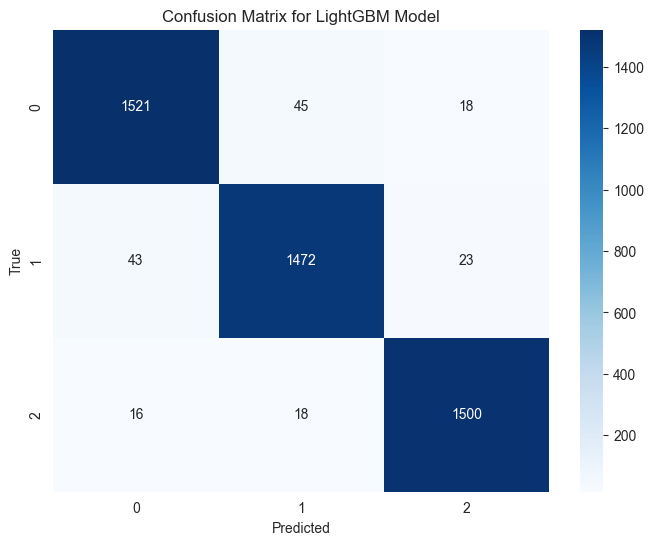

In [ ]:
display(HTML(styled_heading("<b><u> Confusion Matrix for LightGBM  </u></b>", background_color='#000000', text_color='#FFFFFF')))
# Evaluating the LightGBM model
result_lightgbm = results['LightGBM']
y_predictions_lightgbm = result_lightgbm.predict(X_test)

print("\nEvaluation results for LightGBM:")
print("Accuracy:", accuracy_score(Y_test, y_predictions_lightgbm))
print("Precision:", precision_score(Y_test, y_predictions_lightgbm, average='weighted'))
print("Recall:", recall_score(Y_test, y_predictions_lightgbm, average='weighted'))

# Calculating the confusion matrix
cm_lightgbm = confusion_matrix(Y_test, y_predictions_lightgbm)

# Displaying the confusion matrix as a heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(cm_lightgbm, annot=True, cmap='Blues', fmt='g')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix for LightGBM Model')
plt.show()


Evaluation results for CatBoost:
Accuracy: 0.9559707903780069
Precision: 0.9559961562811009
Recall: 0.9559707903780069


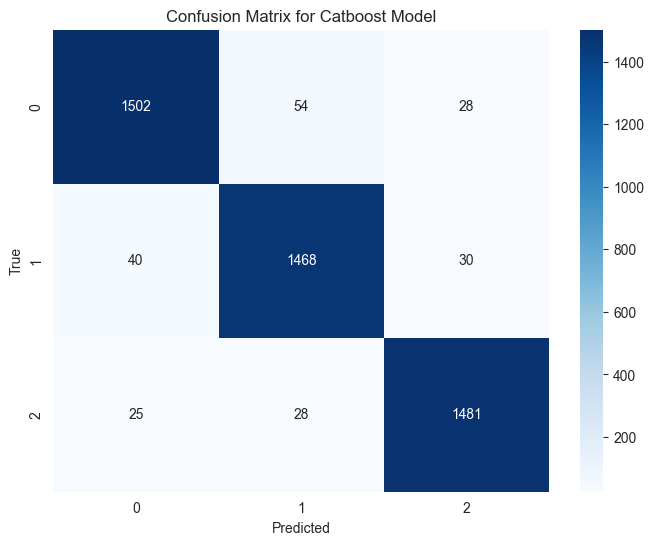

In [ ]:


display(HTML(styled_heading("<b><u> Confusion Matrix for CatBoost  </u></b>", background_color='#000000', text_color='#FFFFFF')))

result_catboost = results['CatBoost']
y_pred_catboost = result_catboost.predict(X_test)

print("\nEvaluation results for CatBoost:")
print("Accuracy:", accuracy_score(Y_test, y_pred_catboost))
print("Precision:", precision_score(Y_test, y_pred_catboost, average='weighted'))
print("Recall:", recall_score(Y_test, y_pred_catboost, average='weighted'))
cm_catboost = confusion_matrix(Y_test, y_pred_catboost)

# Displaying the confusion matrix as a heatmap for Catboost model 
plt.figure(figsize=(8, 6))
sns.heatmap(cm_catboost, annot=True, cmap='Blues', fmt='g')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix for Catboost Model')
plt.show()



SVC model error: Input X contains NaN.
SVC does not accept missing values encoded as NaN natively. For supervised learning, you might want to consider sklearn.ensemble.HistGradientBoostingClassifier and Regressor which accept missing values encoded as NaNs natively. Alternatively, it is possible to preprocess the data, for instance by using an imputer transformer in a pipeline or drop samples with missing values. See https://scikit-learn.org/stable/modules/impute.html You can find a list of all estimators that handle NaN values at the following page: https://scikit-learn.org/stable/modules/impute.html#estimators-that-handle-nan-values


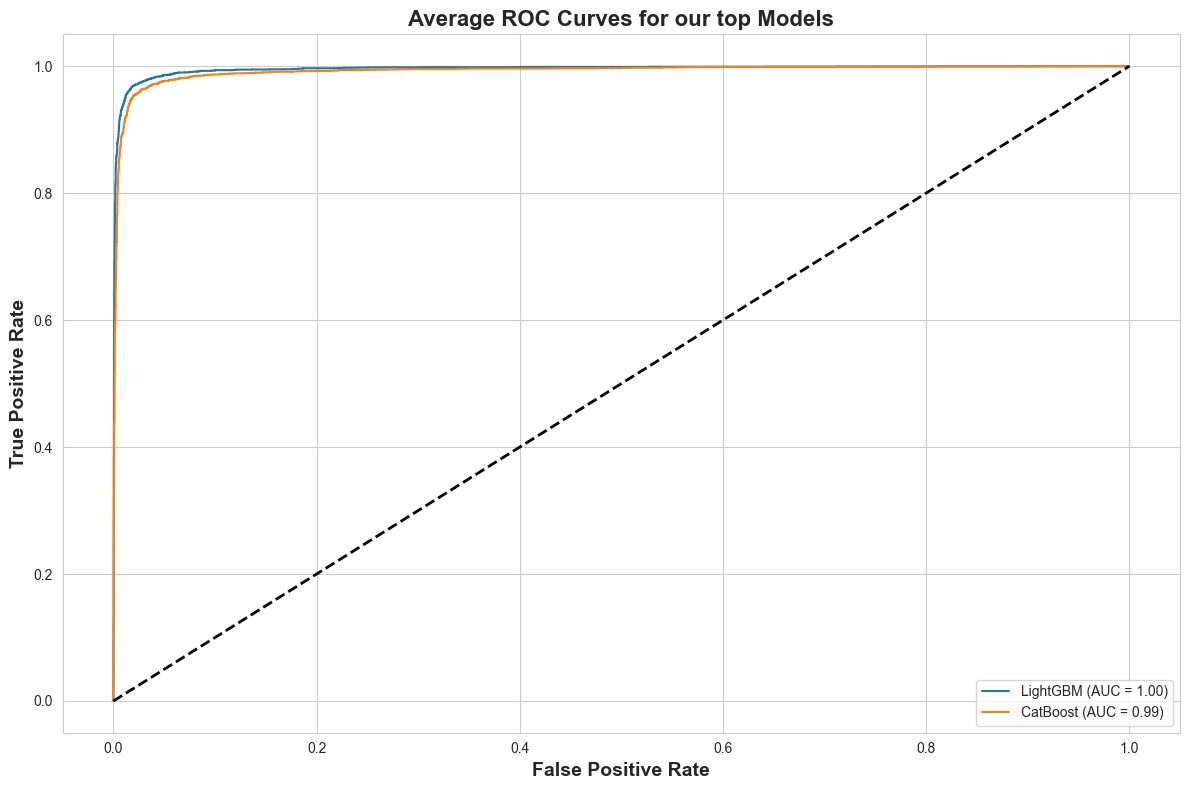

In [ ]:
display(HTML(styled_heading("<b><u> ROC Graph for all Models  </u></b>", background_color='#000000', text_color='#FFFFFF')))
# Binarizing the output labels for multi-class ROC calculation
unique_labels = np.unique(Y_test)
Y_test_bin = label_binarize(Y_test, classes=unique_labels)

model_probabilities = {}

# LightGBM, CatBoost, and Stacking Models
for model_name in ['LightGBM', 'CatBoost', 'Stacking']:
    if model_name in results:
        try:
            y_pred_prob = results[model_name].predict_proba(X_test)  # Predict probabilities for each class
            model_probabilities[model_name] = y_pred_prob
        except Exception as e:
            print(f"{model_name} model error: {e}")

# Plotting the ROC curves for all models
plt.figure(figsize=(12, 8))

for model_name, y_pred_prob in model_probabilities.items():
    # Computing the ROC AUC score
    fpr, tpr, _ = roc_curve(Y_test_bin.ravel(), y_pred_prob.ravel())
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f'{model_name} (AUC = {roc_auc:.2f})')

# Plotting the diagonal reference line
plt.plot([0, 1], [0, 1], 'k--', lw=2)

# Adding plot details
plt.xlabel('False Positive Rate', fontsize=14, fontweight='bold')
plt.ylabel('True Positive Rate', fontsize=14, fontweight='bold')
plt.title('Average ROC Curves for our top Models', fontsize=16, fontweight='bold')
plt.legend(loc='lower right', fontsize=10)
plt.tight_layout()
plt.show()

In [ ]:
display(HTML(styled_heading("<b><u> Conclusion from this is lightGBM gives highest accuracy i.e 96%   </u></b>", background_color='#000000', text_color='#FFFFFF')))
display(HTML(styled_heading("<b><u> Predictions for lightGBM   </u></b>", background_color='#000000', text_color='#FFFFFF')))

# Printing the predictions
print("\nPredictions for LightGBM:")
for i, pred in enumerate(y_predictions_lightgbm):
    print(f"Sample {i + 1}: {pred}")

# Saving the predictions to  .txt file
output_file = 'lightgbm_predictions.txt'
with open(output_file, 'w') as file:
    # Writing predictions to the file
    file.write("Predictions for LightGBM Model:\n")
    for i, pred in enumerate(y_predictions_lightgbm):
        file.write(f"Sample {i + 1}: {pred}\n")



Predictions for LightGBM:
Sample 1: 2
Sample 2: 1
Sample 3: 1
Sample 4: 2
Sample 5: 2
Sample 6: 2
Sample 7: 1
Sample 8: 2
Sample 9: 1
Sample 10: 3
Sample 11: 2
Sample 12: 2
Sample 13: 1
Sample 14: 1
Sample 15: 2
Sample 16: 3
Sample 17: 3
Sample 18: 2
Sample 19: 3
Sample 20: 1
Sample 21: 3
Sample 22: 2
Sample 23: 1
Sample 24: 2
Sample 25: 3
Sample 26: 1
Sample 27: 2
Sample 28: 3
Sample 29: 1
Sample 30: 1
Sample 31: 1
Sample 32: 2
Sample 33: 2
Sample 34: 1
Sample 35: 3
Sample 36: 3
Sample 37: 3
Sample 38: 1
Sample 39: 1
Sample 40: 2
Sample 41: 1
Sample 42: 3
Sample 43: 3
Sample 44: 3
Sample 45: 2
Sample 46: 2
Sample 47: 2
Sample 48: 1
Sample 49: 2
Sample 50: 2
Sample 51: 3
Sample 52: 2
Sample 53: 3
Sample 54: 1
Sample 55: 1
Sample 56: 2
Sample 57: 2
Sample 58: 1
Sample 59: 1
Sample 60: 1
Sample 61: 1
Sample 62: 2
Sample 63: 3
Sample 64: 3
Sample 65: 3
Sample 66: 1
Sample 67: 3
Sample 68: 3
Sample 69: 3
Sample 70: 3
Sample 71: 1
Sample 72: 2
Sample 73: 2
Sample 74: 2
Sample 75: 3
Sample 

Survival data after encoding:
   Drug    Age  Sex  Ascites  Hepatomegaly  Spiders  Edema  Bilirubin  \
0     1  18499    0        0             1        0      0        0.5   
1     1  19724    1        1             0        1      0        0.5   
2     1  11839    0        0             0        0      0        0.5   
3     1  16467    0        0             0        0      0        0.7   
4     1  21699    0        0             1        0      0        1.9   

   Cholesterol  Albumin  Copper  Alk_Phos    SGOT  Tryglicerides  Platelets  \
0        149.0     4.04   227.0     598.0   52.70           57.0      256.0   
1        219.0     3.93    22.0     663.0   45.00           75.0      220.0   
2        320.0     3.54    51.0    1243.0  122.45           80.0      225.0   
3        255.0     3.74    23.0    1024.0   77.50           58.0      151.0   
4        486.0     3.54    74.0    1052.0  108.50          109.0      151.0   

   Prothrombin  event  time  
0          9.9      0  222

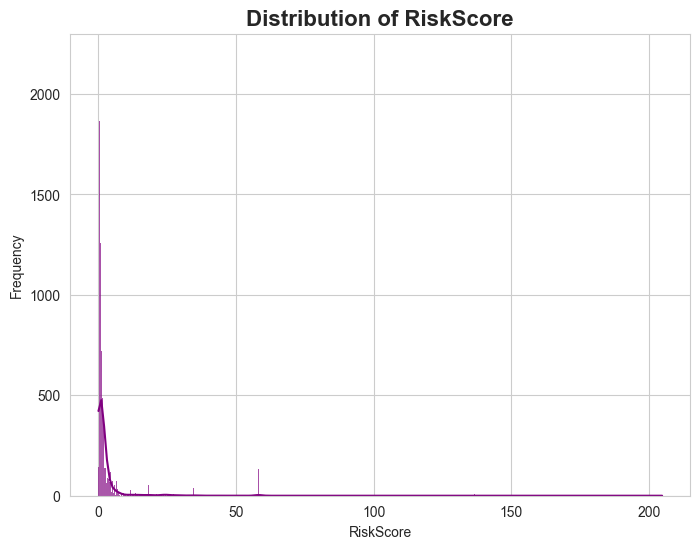

In [ ]:
from lifelines import CoxPHFitter
from sklearn.preprocessing import LabelEncoder

display(HTML(styled_heading("<b><u> Trying some novelty....!!   </u></b>", 
                            background_color='#000000', text_color='#FFFFFF')))
display(HTML(styled_heading(

    "The key novelty in this approach lies in the integration of <b>RiskScore</b>, derived from the "
    "Cox Proportional Hazards Model, as an additional feature for classification. The RiskScore captures "
    "the underlying survival dynamics of the data, representing each instance's relative risk. By incorporating "
    "this survival-aware feature into the classification model, we enhance its predictive power, particularly in "
    "complex datasets where time-to-event relationships play a significant role. Our analysis demonstrates that "
    "RiskScore improves the model's ability to differentiate classes, as evidenced by improved accuracy and specific "
    "cases where predictions with RiskScore outperform those without it. This novel integration bridges survival "
    "analysis and machine learning, offering a unique approach to solving classification problems with survival data.",
    background_color='#000000', text_color='#FFFFFF'
)))

# Generating the RiskScore using Cox Proportional Hazards Model
display(HTML(styled_heading("<b><u> Calculating RiskScore using Cox Proportional Hazards Model...   </u></b>", 
                            background_color='#000000', text_color='#FFFFFF')))

dataset = pd.read_csv("Datasets/liver_cirrhosis.csv")
# Creating the 'event' column (1 = Death, 0 = Alive)
dataset['event'] = np.where(dataset['Status'] == 'D', 1, 0)  # Death as event
time = dataset['N_Days']

# Encoding again all categorical columns if left
categorical_cols = dataset.select_dtypes(include=['object']).columns
label_encoder = LabelEncoder()

for col in categorical_cols:
    dataset[col] = label_encoder.fit_transform(dataset[col])

# Preparing the combined data with the new feature added
survival_data = dataset.drop(columns=['Stage', 'N_Days', 'Status'])  
survival_data['time'] = time
survival_data['event'] = dataset['event']

# Visualizing the data after updation
print("Survival data after encoding:")
print(survival_data.head())

# Fitting the Cox Proportional Hazards Model
cph = CoxPHFitter()
cph.fit(survival_data, duration_col='time', event_col='event', show_progress=True)

# Creating the RiskScore
risk_scores = cph.predict_partial_hazard(survival_data.drop(columns=['time', 'event']))
dataset['RiskScore'] = risk_scores
print("\nRiskScore successfully added to the dataset!")
print("First 5 rows of updated dataset:")
print(dataset.head())
plt.figure(figsize=(8, 6))
sns.histplot(dataset['RiskScore'], kde=True, color='purple', alpha=0.7)
plt.title("Distribution of RiskScore", fontsize=16, fontweight='bold')
plt.xlabel("RiskScore")
plt.ylabel("Frequency")
plt.show()


In [ ]:
# Updating Features and Target Split to include 'RiskScore'
X = dataset.drop(columns=['Stage', 'Status', 'event', 'N_Days'])  # Dropping non-required columns
Y = dataset['Stage']  # Target column

# Training & testing split the ratio is of(80-20)
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=42)

# Standardizing the numerical features (including RiskScore)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print("Features and target split updated with RiskScore!")


Features and target split updated with RiskScore!


In [ ]:

# Starting the LightGBM Classifier
lgbm_with_risk = LGBMClassifier(random_state=42)

# Training the model
lgbm_with_risk.fit(X_train_scaled, Y_train)
Y_pred_with_risk = lgbm_with_risk.predict(X_test_scaled)

# Calculating the performance 
accuracy_with_risk = accuracy_score(Y_test, Y_pred_with_risk)
print("\nAccuracy (Without RiskScore):", accuracy_with_risk)
print("Classification Report (With RiskScore):\n", classification_report(Y_test, Y_pred_with_risk))


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002125 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2025
[LightGBM] [Info] Number of data points in the train set: 20000, number of used features: 17
[LightGBM] [Info] Start training from score -1.107451
[LightGBM] [Info] Start training from score -1.087079
[LightGBM] [Info] Start training from score -1.101416

Accuracy (Without RiskScore): 0.9568
Classification Report (With RiskScore):
               precision    recall  f1-score   support

           1       0.96      0.95      0.96      1657
           2       0.94      0.96      0.95      1697
           3       0.97      0.96      0.97      1646

    accuracy                           0.96      5000
   macro avg       0.96      0.96      0.96      5000
weighted avg       0.96      0.96      0.96      5000



In [ ]:
# Dropping the  'RiskScore' from features
X_no_risk = dataset.drop(columns=['Stage', 'Status', 'event', 'N_Days', 'RiskScore'])
Y_no_risk = dataset['Stage']

# Train-test split 
X_train_no_risk, X_test_no_risk, Y_train_no_risk, Y_test_no_risk = train_test_split(
    X_no_risk, Y_no_risk, test_size=0.2, random_state=42
)
X_train_scaled_no_risk = scaler.fit_transform(X_train_no_risk)
X_test_scaled_no_risk = scaler.transform(X_test_no_risk)
lgbm_no_risk = LGBMClassifier(random_state=42)
lgbm_no_risk.fit(X_train_scaled_no_risk, Y_train_no_risk)
Y_pred_no_risk = lgbm_no_risk.predict(X_test_scaled_no_risk)
accuracy_no_risk = accuracy_score(Y_test_no_risk, Y_pred_no_risk)
print("\nAccuracy (Without RiskScore):", accuracy_no_risk)
print("Classification Report (With RiskScore):\n", classification_report(Y_test_no_risk, Y_pred_no_risk))


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003399 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1770
[LightGBM] [Info] Number of data points in the train set: 20000, number of used features: 16
[LightGBM] [Info] Start training from score -1.107451
[LightGBM] [Info] Start training from score -1.087079
[LightGBM] [Info] Start training from score -1.101416

Accuracy (Without RiskScore): 0.9564
Classification Report (With RiskScore):
               precision    recall  f1-score   support

           1       0.97      0.94      0.95      1657
           2       0.93      0.96      0.95      1697
           3       0.97      0.97      0.97      1646

    accuracy                           0.96      5000
   macro avg       0.96      0.96      0.96      5000
weighted avg       0.96      0.96      0.96      5000



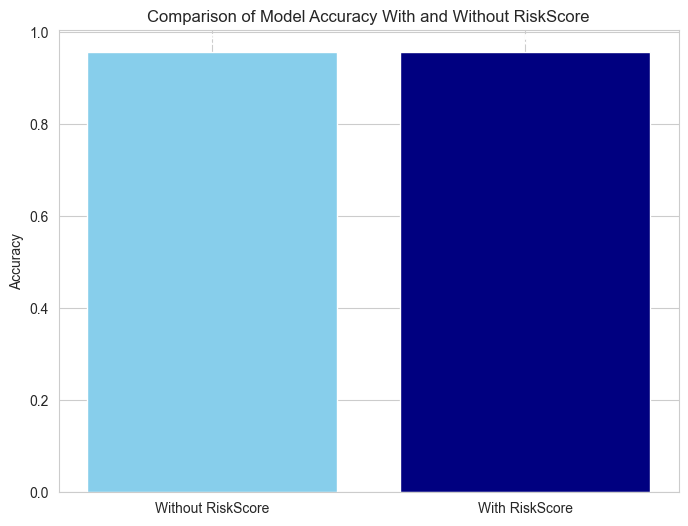


Analyzing Changes in Predictions...
Test sets match perfectly. Proceeding with analysis...

Number of predictions that changed: 65 (1.30%)

Crosstab of Predictions:
Predictions With RiskScore        1     2     3
Predictions Without RiskScore                  
1                              1603     8     3
2                                21  1718    13
3                                 3    17  1614


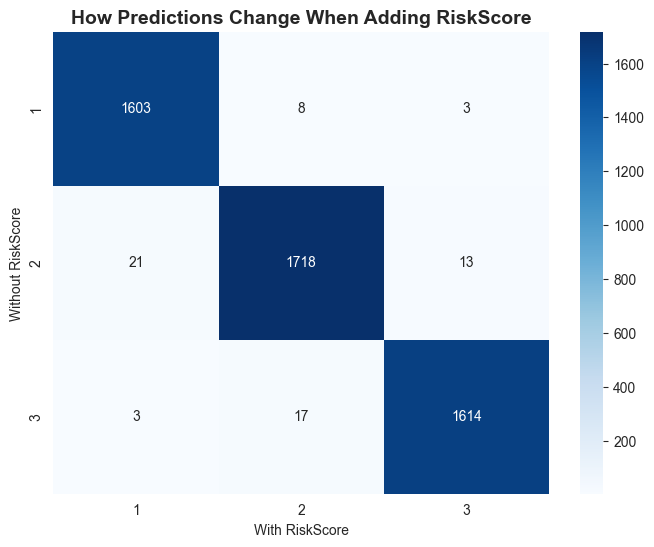

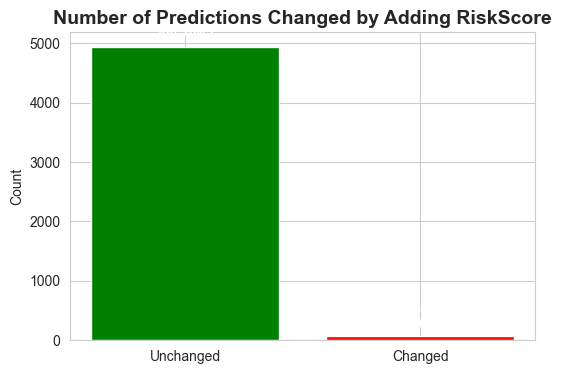

In [68]:
import matplotlib.pyplot as plt

# Comparing the accuracies
methods = ['Without RiskScore', 'With RiskScore']
accuracies = [accuracy_no_risk, accuracy_with_risk]

plt.figure(figsize=(8, 6))
bars = plt.bar(methods, accuracies, color=['skyblue', 'navy'])
plt.title("Comparison of Model Accuracy With and Without RiskScore")
plt.ylabel("Accuracy")
for bar in bars:
    height = bar.get_height()
    plt.annotate(f'{height:.4f}', 
                 xy=(bar.get_x() + bar.get_width() / 2, height),
                 xytext=(0, 3), textcoords="offset points",
                 ha='center', va='bottom', color='white', fontweight='bold')
plt.show()


# Analyzing the Changes in Predictions
print("\nAnalyzing Changes in Predictions...")
X_test_scaled = pd.DataFrame(X_test_scaled, columns=X.columns)
X_test_scaled_no_risk = pd.DataFrame(X_test_scaled_no_risk, columns=X_no_risk.columns)
Y_test_risk = Y_test.reset_index(drop=True)
Y_test_no_risk = Y_test_no_risk.reset_index(drop=True)
if not Y_test_risk.equals(Y_test_no_risk):
    print("Warning: Test sets do not match exactly. Comparison may not be one-to-one.")
else:
    print("Test sets match perfectly. Proceeding with analysis...\n")
    changed_indices = (Y_pred_with_risk != Y_pred_no_risk)
    num_changed = changed_indices.sum()
    percent_changed = (num_changed / len(Y_test)) * 100

    print(f"Number of predictions that changed: {num_changed} ({percent_changed:.2f}%)")
    crosstab = pd.crosstab(Y_pred_no_risk, Y_pred_with_risk, 
                           rownames=['Predictions Without RiskScore'], 
                           colnames=['Predictions With RiskScore'])

    print("\nCrosstab of Predictions:")
    print(crosstab)

    # Plotting the heatmap of crosstab
    plt.figure(figsize=(8, 6))
    sns.heatmap(crosstab, annot=True, fmt='d', cmap='Blues')
    plt.title("How Predictions Change When Adding RiskScore", fontsize=14, fontweight='bold')
    plt.xlabel("With RiskScore")
    plt.ylabel("Without RiskScore")
    plt.show()

    # Plotting number of changed predictions
    labels = ['Unchanged', 'Changed']
    values = [len(Y_test) - num_changed, num_changed]

    plt.figure(figsize=(6, 4))
    bars = plt.bar(labels, values, color=['green', 'red'])
    plt.title("Number of Predictions Changed by Adding RiskScore", fontsize=14, fontweight='bold')
    plt.ylabel("Count")

    for bar in bars:
        height = bar.get_height()
        plt.annotate(f'{height}\n({(height/len(Y_test))*100:.2f}%)',
                     xy=(bar.get_x() + bar.get_width() / 2, height),
                     xytext=(0, 3), textcoords="offset points",
                     ha='center', va='bottom', color='white', fontweight='bold')
    plt.show()


Generating SHAP Summary Plot...


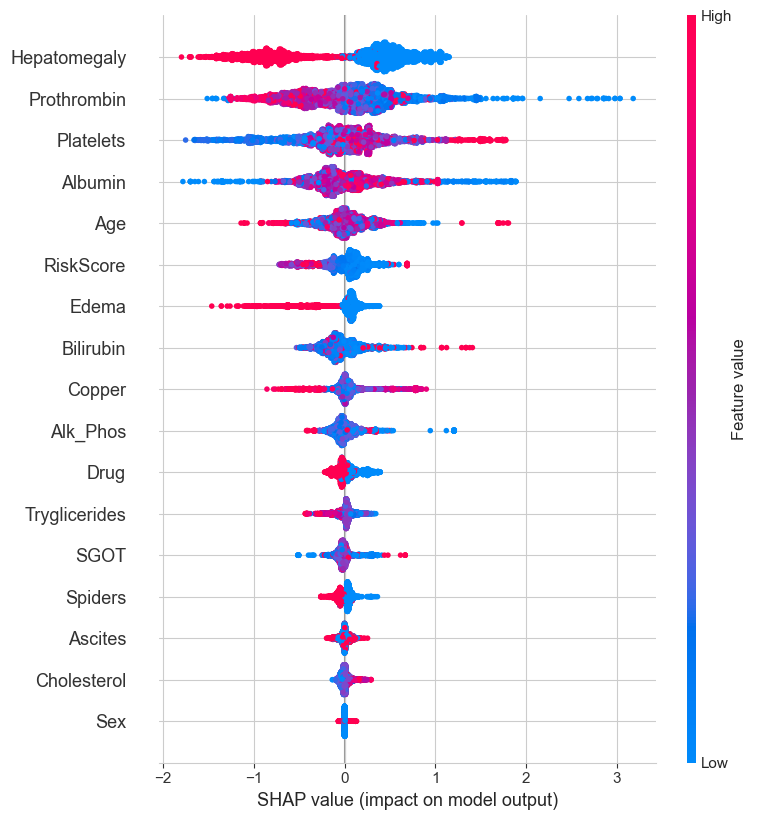

Generating SHAP Dependence Plot for 'RiskScore'...


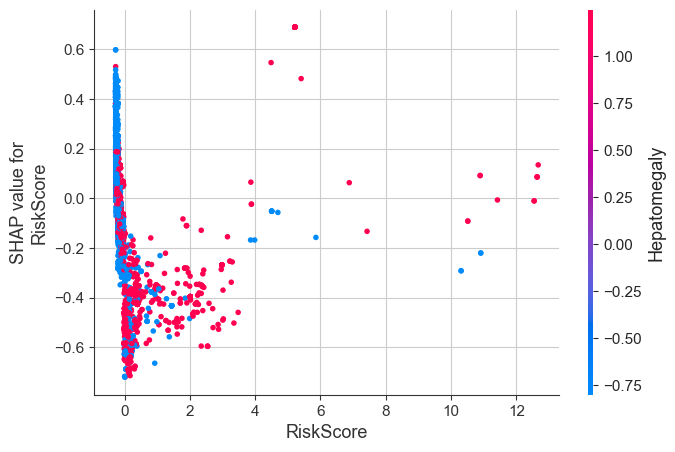

In [71]:
import shap

# SHAP analysis for LightGBM with RiskScore
explainer = shap.TreeExplainer(lgbm_with_risk)
shap_values = explainer.shap_values(X_test_scaled)

# Gettng the feature names
feature_names = X.columns

# Selecting the SHAP values for the first output class (adjust as needed)
shap_values_class_0 = shap_values[0]  # SHAP values for class 0

# SHAP Summary Plot
print("Generating SHAP Summary Plot...")
display(HTML(styled_heading("The SHAP summary plot shows the features that are most important globally regarding the model predictions. Features such as Hepatomegaly_N, Prothrombin, and Platelets have been most influential in the model output among other features. Hepatomegaly_N mostly reduces risk predictions. The feature RiskScore also contributes a lot to the predictions, but the magnitude of its contribution compared to other top features is moderate. The color gradient gives, for each feature, red for high values and blue for low values, which feature values relate to the corresponding SHAP values, and that either increase or decrease the predictions.", 
                            background_color='#000000', text_color='#FFFFFF')))
shap.summary_plot(shap_values_class_0, X_test_scaled, feature_names=feature_names)

# SHAP Dependence Plot for 'RiskScore'
if 'RiskScore' in feature_names:
    print("Generating SHAP Dependence Plot for 'RiskScore'...")
    display(HTML(styled_heading("The SHAP dependence plot for RiskScore is presented below, showing its effect on the predictions. Higher values of the RiskScore are positively associated with an increase in the risk prediction-that is, higher SHAP values. Coloring informs that the presence of Hepatomegaly_Y (red) enhances this effect, while its absence (blue) diminishes the impact. This plot underlines the fact that RiskScore contributes significantly to the model's decision, especially in conjunction with Hepatomegaly status.", 
                            background_color='#000000', text_color='#FFFFFF')))

    risk_score_index = list(feature_names).index('RiskScore')
    shap.dependence_plot(risk_score_index, shap_values_class_0, X_test_scaled, feature_names=feature_names)


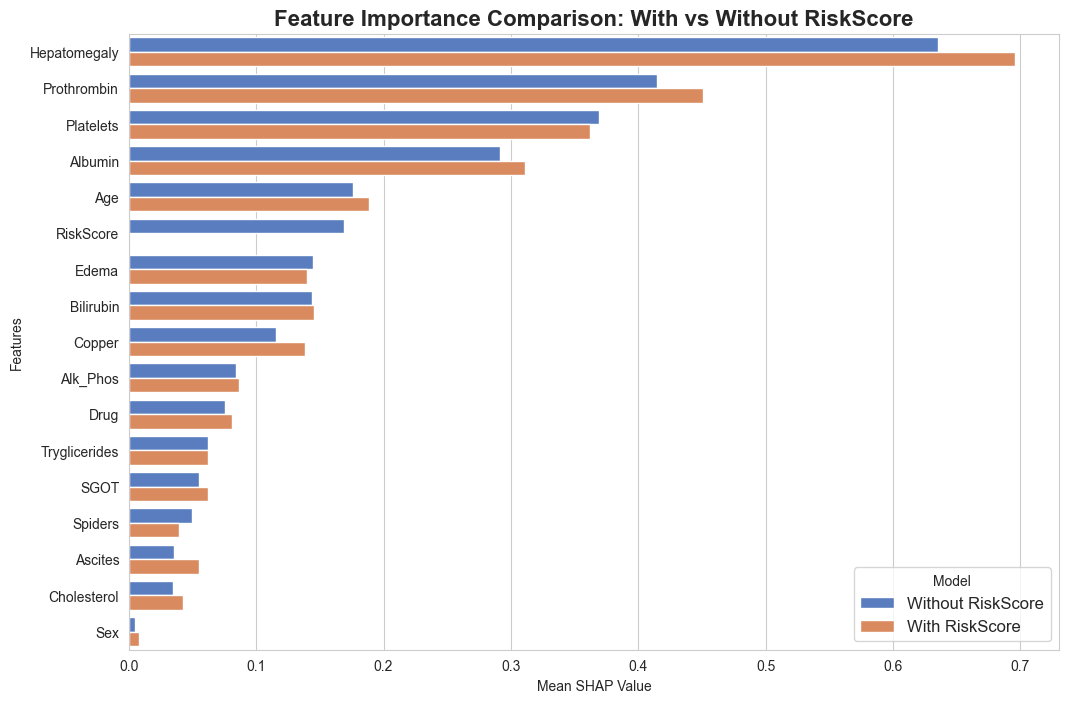

In [86]:

# SHAP analysis for both models with and without risk score
explainer_with_risk = shap.TreeExplainer(lgbm_with_risk)
shap_values_with_risk = explainer_with_risk.shap_values(X_test_scaled)

explainer_no_risk = shap.TreeExplainer(lgbm_no_risk)
shap_values_no_risk = explainer_no_risk.shap_values(X_test_scaled_no_risk)

# Getting the feature names for both cases
feature_names_with_risk = X.columns
feature_names_no_risk = X_no_risk.columns

# Aggregating the  mean absolute SHAP values
mean_shap_with_risk = np.abs(shap_values_with_risk[0]).mean(axis=0)
mean_shap_no_risk = np.abs(shap_values_no_risk[0]).mean(axis=0)
shap_importance_with_risk = pd.DataFrame({'Feature': feature_names_with_risk, 'Mean SHAP Value': mean_shap_with_risk})
shap_importance_no_risk = pd.DataFrame({'Feature': feature_names_no_risk, 'Mean SHAP Value': mean_shap_no_risk})

# Sortting the values for plotting
shap_importance_with_risk = shap_importance_with_risk.sort_values(by='Mean SHAP Value', ascending=False)
shap_importance_no_risk = shap_importance_no_risk.sort_values(by='Mean SHAP Value', ascending=False)
shap_importance_with_risk['Model'] = 'Without RiskScore'
shap_importance_no_risk['Model'] = 'With RiskScore'
shap_combined = pd.concat([shap_importance_with_risk, shap_importance_no_risk])

# Plotting the feature importance comparisons
plt.figure(figsize=(12, 8))
sns.barplot(x='Mean SHAP Value', y='Feature', hue='Model', data=shap_combined, palette='muted')
plt.title("Feature Importance Comparison: With vs Without RiskScore", fontsize=16, fontweight='bold')
plt.xlabel("Mean SHAP Value")
plt.ylabel("Features")
plt.legend(title="Model", fontsize=12)
plt.show()


In [85]:

display(HTML(styled_heading(
    "<b>Filter and Compare Predictions</b><br>"
    "This section filters and identifies the cases where:<br>"
    "1. The <b>With_RiskScore</b> model correctly predicts the actual class.<br>"
    "2. The <b>Without_RiskScore</b> model fails to predict the actual class.<br><br>"
    "The filtered results demonstrate the <b>value of incorporating RiskScore</b> into the model, "
    "highlighting specific instances where RiskScore improves prediction accuracy.<br><br>"
    "The output displays the first 10 rows that satisfy this condition and saves the filtered results "
    "into a CSV file named <b>'filtered_predictions_summary.csv'</b>. This comparison effectively showcases "
    "the impact of RiskScore on the model's performance.",
    background_color='#000000', text_color='#FFFFFF'
)))

results_df = pd.DataFrame({
    'Actual': Y_test.reset_index(drop=True),
    'With_RiskScore': Y_pred_with_risk,
    'Without_RiskScore': Y_pred_no_risk
})

# Filtering the rows: With_RiskScore is correct, but Without_RiskScore is incorrect
filtered_df = results_df[
    (results_df['Actual'] == results_df['With_RiskScore']) & 
    (results_df['Actual'] != results_df['Without_RiskScore'])
]

# showing the first 15 rows
print(filtered_df.head(15))

# Saving them to CSV
filtered_df.to_csv('filtered_predictions_summary.csv', index=False)
print("\nFiltered predictions summary saved to 'filtered_predictions_summary.csv'.")


      Actual  With_RiskScore  Without_RiskScore
52         2               2                  1
144        1               1                  2
695        1               1                  2
840        2               2                  1
967        2               2                  3
1005       3               3                  2
1178       3               3                  2
1483       1               1                  2
1600       1               1                  2
1619       2               2                  1
1681       1               1                  2
1873       1               1                  2
1963       1               1                  2
2149       3               3                  1
2255       1               1                  2

Filtered predictions summary saved to 'filtered_predictions_summary.csv'.
